# Project 7:  Airport Data Analysis

In [205]:
import pandas as pd 
import matplotlib 
from matplotlib import pyplot as plt
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import psycopg2 as psy
import seaborn as sns
from sqlalchemy import create_engine
from matplotlib import cm
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA 
import pylab
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Import and examine data 

In [206]:
cancel = pd.read_csv('../assets/cancellations.csv')
operations = pd.read_csv('../assets/operations.csv')
airports = pd.read_csv('../assets/airports.csv')

In [207]:
print 'Dataframe   Shape'
print 'cancel:     ' + str(cancel.shape)
print 'operations: ' + str(operations.shape)
print 'airports:   ' + str(airports.shape)

Dataframe   Shape
cancel:     (805, 6)
operations: (841, 15)
airports:   (5167, 13)


### Check out cancel dataframe:

In [208]:
cancel.head(2)

Airport    Year  Departure Cancellations  Arrival Cancellations  \
0     ABQ  2004.0                    242.0                  235.0   
1     ABQ  2005.0                    221.0                  190.0   

   Departure Diversions  Arrival Diversions  
0                  71.0                46.0  
1                  61.0                33.0

In [209]:
cancel.columns = ['Airport', 'Year', 'dep cancel', 'arr cancel', 'dep divers', 'arr divers']

In [210]:
cancel.dtypes

Airport        object
Year          float64
dep cancel    float64
arr cancel    float64
dep divers    float64
arr divers    float64
dtype: object

In [211]:
cancel.isnull().sum()

Airport       0
Year          0
dep cancel    0
arr cancel    0
dep divers    0
arr divers    0
dtype: int64

In [212]:
set(cancel['Airport'].value_counts())

{6, 7, 11}

In [213]:
cancel['Airport'].value_counts(ascending = True).head(5)

RFD     6
OXR     7
JFK    11
DAL    11
PBI    11
Name: Airport, dtype: int64

In [214]:
len(cancel['Airport'].value_counts())

74

From the previous three cells, we see that there are 74 unique airports listed, and that there are eleven observations per airport except for OXR and RFD, for which there are seven and six, respectively.

RFD is in Rockford, IL:

In [215]:
cancel[cancel['Airport'] == 'RFD']

Airport    Year  dep cancel  arr cancel  dep divers  arr divers
634     RFD  2006.0         9.0        11.0         2.0         8.0
635     RFD  2007.0         4.0         7.0         2.0        11.0
636     RFD  2008.0         5.0         2.0         0.0         5.0
637     RFD  2011.0         0.0         0.0         0.0         0.0
638     RFD  2012.0         1.0         1.0         0.0         0.0
639     RFD  2013.0         0.0         0.0         0.0         0.0

OXR is in Oxnard, CA:

In [216]:
cancel[cancel['Airport'] == 'OXR']

Airport    Year  dep cancel  arr cancel  dep divers  arr divers
539     OXR  2004.0        43.0        37.0         0.0         0.0
540     OXR  2005.0        33.0        22.0         0.0         0.0
541     OXR  2006.0        51.0        44.0         2.0         1.0
542     OXR  2007.0        21.0        17.0         1.0         0.0
543     OXR  2008.0        20.0        20.0         1.0         0.0
544     OXR  2009.0        27.0        24.0         0.0         0.0
545     OXR  2010.0        10.0         8.0         0.0         0.0

Judging by number of flights listed for these two airports, they seem tiny.  We're also missing the most recent year(s) for both of them.  We'll keep them in for now.

In [217]:
cancel['Year'].value_counts()

2008.0    74
2007.0    74
2006.0    74
2013.0    73
2012.0    73
2011.0    73
2010.0    73
2009.0    73
2005.0    73
2004.0    73
2014.0    72
Name: Year, dtype: int64

In [218]:
cancel['dep cancel'].describe()

count      805.000000
mean      1292.038509
std       1835.961943
min          0.000000
25%        349.000000
50%        663.000000
75%       1472.000000
max      16618.000000
Name: dep cancel, dtype: float64

In [219]:
cancel['arr cancel'].describe()

count      805.000000
mean      1333.124224
std       1975.224868
min          0.000000
25%        314.000000
50%        642.000000
75%       1523.000000
max      17571.000000
Name: arr cancel, dtype: float64

In [220]:
cancel['dep divers'].describe()

count     805.000000
mean      173.315528
std       172.345539
min         0.000000
25%        62.000000
50%       110.000000
75%       236.000000
max      1064.000000
Name: dep divers, dtype: float64

In [221]:
cancel['arr divers'].describe()

count     805.000000
mean      169.413665
std       228.521615
min         0.000000
25%        41.000000
50%        84.000000
75%       190.000000
max      1948.000000
Name: arr divers, dtype: float64

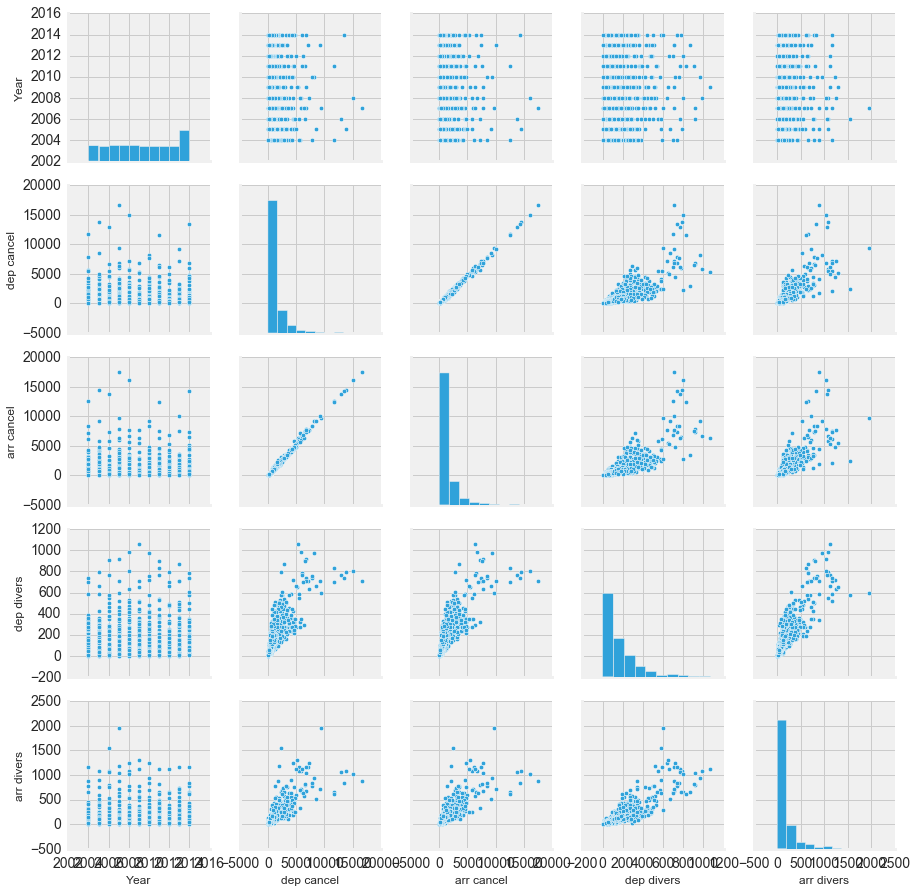

In [222]:
sns.pairplot(cancel)

We don't need both arrival AND departure cancellations, since they're almost completely correlated.  Let's take out departure cancellations on the vague intuition that arrival cancellations imply planes aren't at the airport for departure (and thus departures are cancelled):

In [223]:
del cancel['dep cancel']

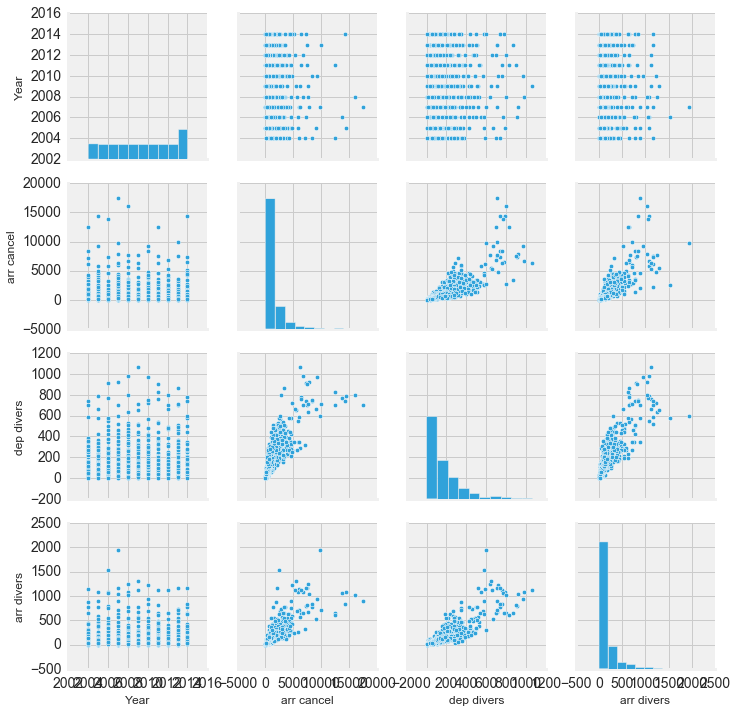

In [228]:
sns.pairplot(cancel)

### Check out airports dataframe:

In [224]:
airports.head(1).T

0
Key                                               3443
LocID                                              STX
AP_NAME                                HENRY E ROHLSEN
ALIAS                    Henry E Rohlsen Int'l Airport
Facility Type                                  Airport
FAA REGION                                         ASO
COUNTY                                -VIRGIN ISLANDS-
CITY                                     CHRISTIANSTED
STATE                                               VI
AP Type                                     Public Use
Latitude                                       17.7016
Longitude                                     -64.8017
Boundary Data Available                            Yes

In [225]:
airports.columns = ['Key', 'LocID', 'AP_NAME', 'ALIAS', 'Facility Type', 'FAA REGION', 'COUNTY', 'CITY', 'STATE',\
                   'AP Type', 'lat', 'long', 'Boundary Data Available']

In [226]:
airports.isnull().sum()

Key                           3
LocID                        15
AP_NAME                       3
ALIAS                      1669
Facility Type                 3
FAA REGION                    3
COUNTY                        3
CITY                          3
STATE                         3
AP Type                       3
lat                           3
long                          3
Boundary Data Available       3
dtype: int64

In [227]:
del airports['ALIAS'] # use 'LocID' instead; this one is wordy

In [228]:
airports[airports['Key'].isnull()]

Key LocID AP_NAME Facility Type FAA REGION COUNTY CITY STATE AP Type  \
5164  NaN   NaN     NaN           NaN        NaN    NaN  NaN   NaN     NaN   
5165  NaN   NaN     NaN           NaN        NaN    NaN  NaN   NaN     NaN   
5166  NaN   NaN     NaN           NaN        NaN    NaN  NaN   NaN     NaN   

      lat  long Boundary Data Available  
5164  NaN   NaN                     NaN  
5165  NaN   NaN                     NaN  
5166  NaN   NaN                     NaN

In [229]:
airports = airports.drop(airports.index[[5164, 5165, 5166]])

Confirm 'LocID' is what we think it is:

In [230]:
airports[airports['LocID'] == 'JFK']

Key LocID              AP_NAME Facility Type FAA REGION  COUNTY  \
2752  2458.0   JFK  JOHN F KENNEDY INTL       Airport        AEA  QUEENS   

          CITY STATE                 AP Type        lat       long  \
2752  NEW YORK    NY  Federalized/Commercial  40.639751 -73.778926   

     Boundary Data Available  
2752                     Yes

In [231]:
airports[airports['LocID'].isnull()][['LocID', 'AP_NAME', 'STATE']]

LocID               AP_NAME STATE
182    NaN       TERLINGUA RANCH    TX
1208   NaN              MORIARTY    NM
1232   NaN               BUFFALO    TX
1233   NaN          MAPLES FIELD    TX
1408   NaN  MIAMI-ROBERTS COUNTY    TX
2670   NaN                PACKER    OH
2789   NaN               CORYDON    IA
3354   NaN           CACKLEBERRY    MI
3546   NaN        SHARPE'S STRIP    MI
3936   NaN                MOORES    NY
4200   NaN           GROTON MUNI    SD
4450   NaN            RICHARDTON    ND

We don't know if these airports will still be around after we merge dataframes, but let's search online and fill in proper 'LocID' entry anyway:

In [235]:
airports['LocID'][182] = '1E2'
airports['LocID'][1208] = '0E0'
airports['LocID'][1232] = '1E7'
airports['LocID'][1233] = '1E9'
airports['LocID'][1408] = '3E0'
airports['LocID'][2670] = '5E9'
airports['LocID'][2789] = '0E9'
airports['LocID'][3354] = '2E8'
airports['LocID'][3546] = '2E2'
airports['LocID'][3936] = '1E8'
airports['LocID'][4200] = '2E6'
airports['LocID'][4450] = '4E8'

In [233]:
airports.isnull().sum()

Key                        0
LocID                      0
AP_NAME                    0
Facility Type              0
FAA REGION                 0
COUNTY                     0
CITY                       0
STATE                      0
AP Type                    0
lat                        0
long                       0
Boundary Data Available    0
dtype: int64

In [234]:
len(airports)

5164

In [236]:
len(airports['LocID'].unique())

5164

In [237]:
airports['Key'].describe()

count    5164.000000
mean     2786.645236
std      1493.693985
min       203.000000
25%      1493.750000
50%      2784.500000
75%      4075.250000
max      5375.000000
Name: Key, dtype: float64

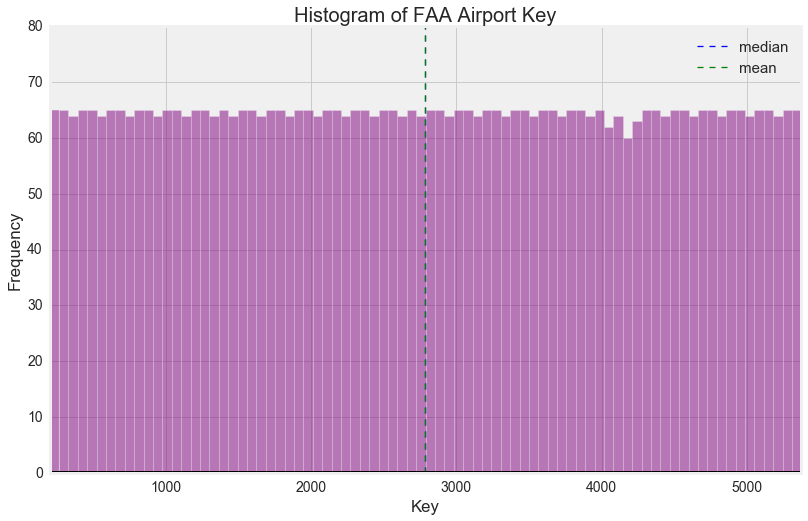

In [238]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(airports['Key'], color = 'purple', alpha = 0.5, bins = 80)
plt.axvline(airports['Key'].median(), color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(airports['Key'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of FAA Airport Key', fontsize = 20)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Key')

plt.xlim([min(airports['Key']), max(airports['Key'])])
plt.ylim([0, 80])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

'Key' values looked approx uniformly-distributed between 203 and 5375.  Let's see if there is any pattern in their georgraphic distribution:

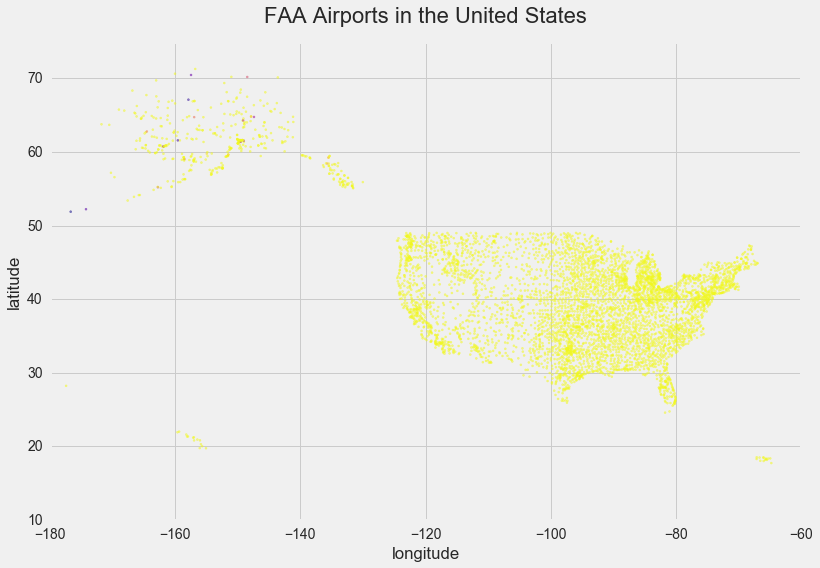

In [239]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

key_color = []
for i in airports['Key']:
    lil_color = cm.plasma((i-203)*256/(5375-203))
    key_color.append(lil_color)

airports['key_color'] = key_color

plt.scatter(airports['long'], airports['lat'], color = airports['key_color'], alpha = 0.5, s = 4)


plt.title('FAA Airports in the United States', fontsize = 22, y = 1.03)

# y label
plt.ylabel('latitude')

# x label
plt.xlabel('longitude')

# set the figure boundaries
plt.xlim([-180, -60])
plt.ylim([10, 75])
plt.grid(True)
#plt.legend(loc='upper right', fontsize = 15)

plt.show()

We'll keep 'Key' in for now, since it does not appear to be randomly assigned.  Does seem like there ought to be more variation in plotting color density, though.

In [240]:
del airports['key_color']

In [241]:
len(airports['AP_NAME'].unique())

4956

Hm, looks like some airport names are repeated, since there aren't 5164 unique names.  Let's look into this by making a list of unique names which appear more than once in the original dataframe  The cell takes a while to run so we put the returned set in markdown underneath:

In [242]:
# dups = []
# for i in range(len(airports)):
#     for j in range(len(airports)):
#         if i > j:
#             if airports['AP_NAME'][i] == airports['AP_NAME'][j]:
#                 dups.append(airports.loc[i]['AP_NAME'])
# print set(dups)

set(['JACKSON MUNI', 'CARROLL COUNTY', 'TAYLOR COUNTY', 'TWIN LAKES', 'LAKE COUNTY', 'JOHNSON COUNTY', 'MC GRATH', 'WASHINGTON COUNTY', 'HUMBOLDT MUNI', 'GREENVILLE MUNI', 'WOOD COUNTY', 'TRI-CITY', 'HAZELTON MUNI', 'PUTNAM COUNTY', 'WAYNE COUNTY', 'PITTSFIELD MUNI', 'HORSESHOE BEND', 'DUBOIS MUNI', 'HOONAH', 'MARION MUNI', 'SUMMIT', 'SHELBY COUNTY', 'NEWPORT STATE', 'WOODBINE MUNI', 'HUNTINGTON MUNI', 'TWIN BRIDGES', 'AUBURN MUNI', 'FAYETTE COUNTY', 'INDEPENDENCE MUNI', 'TUNTUTULIAK', 'SUPERIOR MUNI', 'LAMAR MUNI', 'ALBANY MUNI', 'BOWMAN FIELD', 'CHEROKEE COUNTY', 'HARRISON COUNTY', 'HENRY COUNTY', 'BOONE COUNTY', 'FIELD OF DREAMS', 'YAKUTAT', 'GRAND MARAIS/COOK COUNTY', 'HOUSTON COUNTY', 'OAKLEY MUNI', 'BETHEL', 'COLUMBIA', 'PERRY MUNI', 'KWIGILLINGOK', 'ST GEORGE', 'MONROE COUNTY', 'LAKE LOUISE', 'CORNING MUNI', 'PRINCETON MUNI', 'AKIACHAK', 'COLUMBUS MUNI', 'GARDNER MUNI', 'CLINTON MUNI', 'CASSVILLE MUNI', 'FAIRFIELD COUNTY', 'BUFFALO MUNI', 'FRANKLIN COUNTY', 'EAGLES NEST', 'HAMPTON MUNI', 'CLEVELAND MUNI', 'WESTPORT', 'ORANGE COUNTY', 'HILLSBORO MUNI', 'MANSFIELD MUNI', 'ANVIK', 'NORTH COUNTRY', 'CENTERVILLE MUNI', 'SKAGWAY', 'SIDNEY MUNI', 'ROBERTSON FIELD', 'SKY HARBOR', 'LINCOLN MUNI', 'ISLAND LAKE', 'MOORE COUNTY', 'OSCEOLA MUNI', 'HUNTSVILLE MUNI', 'MAPLE GROVE', 'HENDERSON FIELD', 'MORGAN COUNTY', 'SUNBURY', 'WINNSBORO MUNI', 'MERCER COUNTY', 'FRIDAY HARBOR', 'ENTERPRISE MUNI', 'AKUTAN', 'HAINES', 'FRANKLIN FIELD', 'FLORA MUNI', 'TRI-CITIES', 'RANKIN', 'NEWTOK', 'AUGUSTA', 'LOGAN COUNTY', 'FAIRVIEW', 'HORIZON', 'BOONVILLE', 'CROSBY MUNI', 'EUREKA', 'HAMILTON MUNI', 'SKYHAVEN', 'HARSENS ISLAND', 'FREMONT MUNI', 'MARTIN FIELD', 'LINCOLN', 'ALEXANDRIA', 'CALDWELL MUNI', 'GRANT COUNTY', 'PERRY COUNTY', 'PICKENS COUNTY', 'WARREN MUNI', 'SKY MANOR', 'MARION COUNTY', 'TRACY MUNI', 'ELLINGTON', 'TRENTON MUNI', 'DAVIS FIELD', 'MOUNT PLEASANT MUNI', 'GREENVILLE', 'ARLINGTON MUNI', 'BLOOMFIELD MUNI', 'BEAVER MUNI', 'KAKE', 'RUSK COUNTY', 'MILLER', 'SMYRNA', 'JACKSON COUNTY', 'MARSHALL COUNTY', 'POCAHONTAS MUNI', 'NEWPORT MUNI', 'BENSON MUNI', 'DAVIS', 'WALES', 'EMPIRE', 'WRANGELL', 'KLAWOCK', 'SMITH FIELD', 'FULTON COUNTY', 'OCEAN CITY MUNI', 'LIVINGSTON MUNI', 'RICHLAND', 'PORTLAND MUNI', 'NEWTON MUNI', 'SPRINGFIELD MUNI', 'LEBANON MUNI', 'TRI-COUNTY', 'FAIRFIELD MUNI', 'DOUGLAS MUNI', 'TAYLOR', 'LITCHFIELD MUNI', 'MADISONVILLE MUNI', 'SELDOVIA', 'PLYMOUTH MUNI', 'COTTONWOOD', 'WARSAW MUNI', 'STURGIS MUNI', 'ARNOLD FIELD', 'QUINCY MUNI', 'EUREKA MUNI', 'CALHOUN COUNTY', 'LAWRENCE MUNI', 'CONCHAS LAKE', 'COVINGTON MUNI', 'CAMBRIDGE MUNI', 'LONG LAKE', 'MASON COUNTY', 'MADISON MUNI', 'CAPITAL CITY', 'LA PORTE MUNI'])

Wow, that's long list.  Doing these spot checks, seems like it's exactly what we asked for:

In [243]:
airports[airports['AP_NAME'] == 'LA PORTE MUNI'][['LocID', 'AP_NAME', 'FAA REGION', 'CITY', 'STATE']]

LocID        AP_NAME FAA REGION      CITY STATE
210    T41  LA PORTE MUNI        ASW  LA PORTE    TX
3090   PPO  LA PORTE MUNI        AGL  LA PORTE    IN

In [244]:
airports[airports['AP_NAME'] == 'QUINCY MUNI'][['LocID', 'AP_NAME', 'FAA REGION', 'CITY', 'STATE']]

LocID      AP_NAME FAA REGION    CITY STATE
326    2J9  QUINCY MUNI        ASO  QUINCY    FL
4500   80T  QUINCY MUNI        ANM  QUINCY    WA

In [245]:
airports[airports['AP_NAME'] == 'SKY HARBOR'][['LocID', 'AP_NAME', 'FAA REGION', 'CITY', 'STATE']]

LocID     AP_NAME FAA REGION     CITY STATE
4425   DYT  SKY HARBOR        AGL   DULUTH    MN
4535   9Y5  SKY HARBOR        AGL  EVELETH    MN
4608   S86  SKY HARBOR        ANM   SULTAN    WA

AP_NAME doesn't seem worth keeping, except for ease in interpreting the airport code... let's get rid of it!

In [246]:
del airports['AP_NAME']

In [247]:
airports['Facility Type'].value_counts()

Airport    5164
Name: Facility Type, dtype: int64

Welp, that doesn't help.

In [248]:
del airports['Facility Type']

In [249]:
airports['FAA REGION'].value_counts()

AGL    1074
ASW     769
ASO     745
ANM     649
ACE     473
AEA     468
AAL     406
AWP     397
ANE     183
Name: FAA REGION, dtype: int64

In [250]:
airports['AP Type'].value_counts()

Public Use                4876
Federalized/Commercial     288
Name: AP Type, dtype: int64

Let's just binarize this right now to get it over with:

In [251]:
airports['public'] = airports['AP Type'].apply(lambda x: 1 if x=='Public Use' else 0)
del airports['AP Type']

In [252]:
airports['Boundary Data Available'].value_counts()

Yes    3498
No     1666
Name: Boundary Data Available, dtype: int64

Well, if boundary data is available either we have it or we don't at this point, so this doesn't help.  Remove.

In [253]:
del airports['Boundary Data Available']

In [254]:
airports.head(1).T

0
Key                     3443
LocID                    STX
FAA REGION               ASO
COUNTY      -VIRGIN ISLANDS-
CITY           CHRISTIANSTED
STATE                     VI
lat                  17.7016
long                -64.8017
public                     1

Let's see geographic distribution of public vs federal/commercial airports:

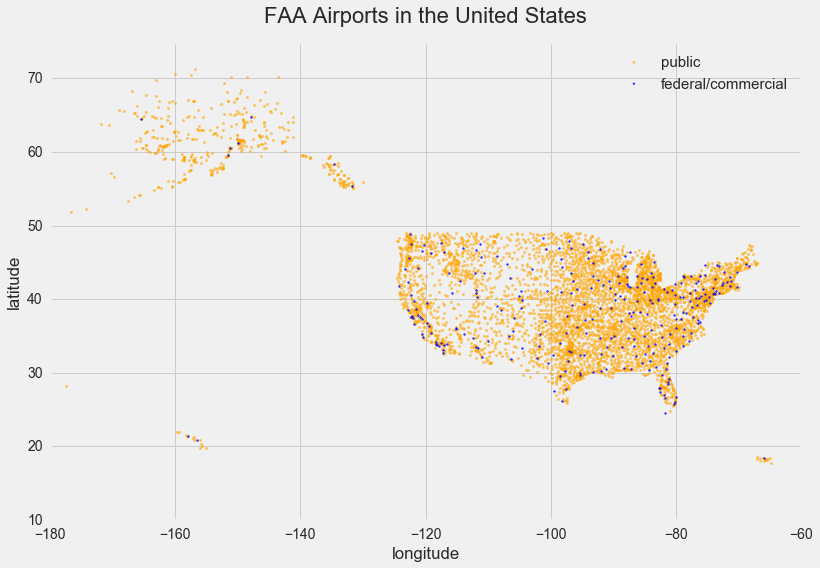

In [255]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

public = airports[airports['public'] == 1]
fed_commercial = airports[airports['public'] != 1]

plt.scatter(public['long'], public['lat'], color = 'orange', alpha = 0.6, s = 5, label = 'public')
plt.scatter(fed_commercial['long'], fed_commercial['lat'], color = 'blue', alpha = 0.8, s = 3, label = \
            'federal/commercial')

plt.title('FAA Airports in the United States', fontsize = 22, y = 1.03)

# y label
plt.ylabel('latitude')

# x label
plt.xlabel('longitude')

# set the figure boundaries
plt.xlim([-180, -60])
plt.ylim([10, 75])
plt.grid(True)
plt.legend(loc='upper right', fontsize = 15)

plt.show()

Zoom in on lower 48...

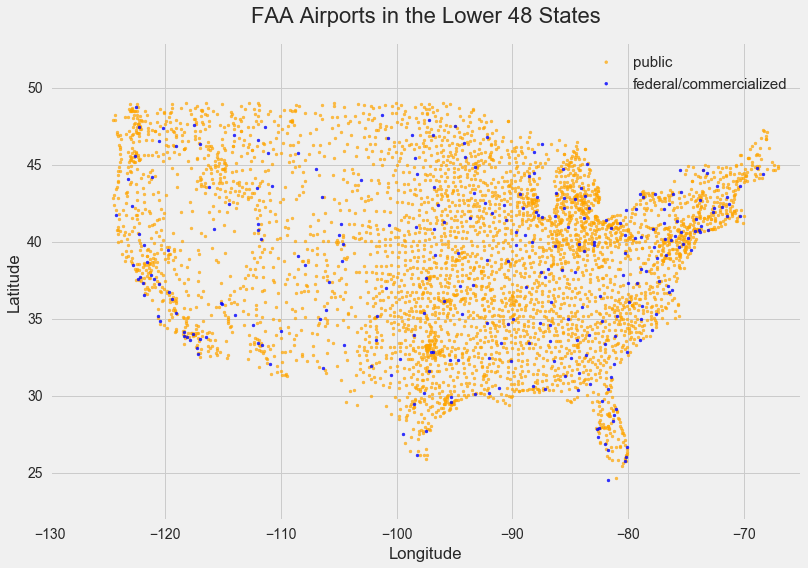

In [256]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(public['long'], public['lat'], color = 'orange', alpha = 0.7, label = 'public', s = 8)
plt.scatter(fed_commercial['long'], fed_commercial['lat'], color = 'blue', alpha = 0.8, s = 8, label = \
            'federal/commercialized')

plt.title('FAA Airports in the Lower 48 States', fontsize = 22, y = 1.03)

# y label
plt.ylabel('Latitude')

# x label
plt.xlabel('Longitude')

# set the figure boundaries
plt.xlim([-130, -65])
plt.ylim([22, 53])
plt.grid(True)
plt.legend(loc='upper right', fontsize = 15)

plt.show()

That's a lot of airports.

What do the FAA regions mean?  Note: the browns blend together, but ANE and AEA are distinct in the northeast and mid-Atlantic seaboard (sidenote: matplotlib could stand a few more qualitative colormaps):

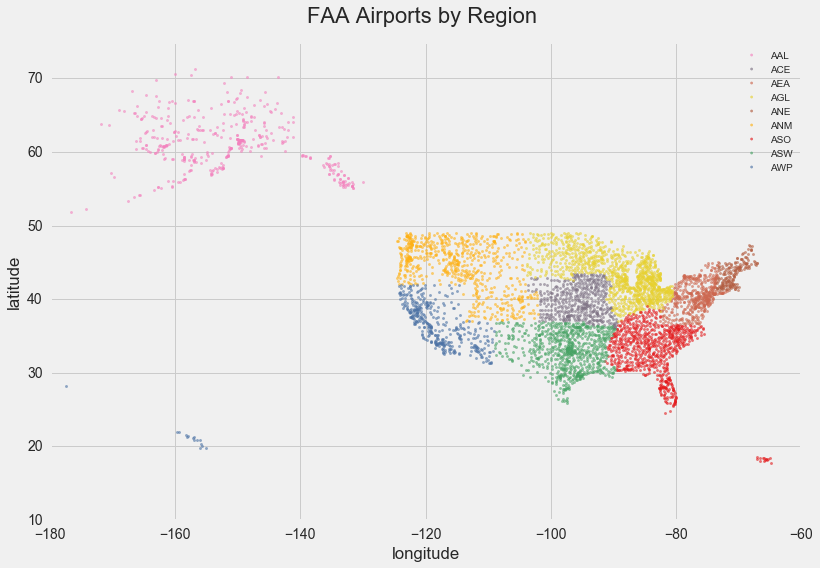

In [257]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

FAA_region = list(airports['FAA REGION'].unique())
FAA_colors = []
for i in range(0, 256, 256/(len(list(airports['FAA REGION'].unique())))):
    FAA_colors.append(cm.Set1(i))
FAA_dict = dict(zip(FAA_region, FAA_colors))

ASO = airports[airports['FAA REGION'] == 'ASO']
AWP = airports[airports['FAA REGION'] == 'AWP']
ASW = airports[airports['FAA REGION'] == 'ASW']
ACE = airports[airports['FAA REGION'] == 'ACE']
AEA = airports[airports['FAA REGION'] == 'AEA']
ANM = airports[airports['FAA REGION'] == 'ANM']
AGL = airports[airports['FAA REGION'] == 'AGL']
ANE = airports[airports['FAA REGION'] == 'ANE']
AAL = airports[airports['FAA REGION'] == 'AAL']
               

plt.scatter(AAL['long'], AAL['lat'], color = FAA_dict['AAL'], alpha = 0.6, label = 'AAL', s = 5)
plt.scatter(ACE['long'], ACE['lat'], color = FAA_dict['ACE'], alpha = 0.6, label = 'ACE', s = 5)
plt.scatter(AEA['long'], AEA['lat'], color = FAA_dict['AEA'], alpha = 0.6, label = 'AEA', s = 5)
plt.scatter(AGL['long'], AGL['lat'], color = FAA_dict['AGL'], alpha = 0.6, label = 'AGL', s = 5)
plt.scatter(ANE['long'], ANE['lat'], color = FAA_dict['ANE'], alpha = 0.6, label = 'ANE', s = 5)
plt.scatter(ANM['long'], ANM['lat'], color = FAA_dict['ANM'], alpha = 0.6, label = 'ANM', s = 5)
plt.scatter(ASO['long'], ASO['lat'], color = FAA_dict['ASO'], alpha = 0.6, label = 'ASO', s = 5)
plt.scatter(ASW['long'], ASW['lat'], color = FAA_dict['ASW'], alpha = 0.6, label = 'ASW', s = 5)
plt.scatter(AWP['long'], AWP['lat'], color = FAA_dict['AWP'], alpha = 0.6, label = 'AWP', s = 5)

# plt.scatter(fed_commercial['Longitude'], fed_commercial['Latitude'], color = 'red', alpha = 0.7, label = \
#             'federal/commercial')

plt.title('FAA Airports by Region ', fontsize = 22, y = 1.03)

# y label
plt.ylabel('latitude')

# x label
plt.xlabel('longitude')

# set the figure boundaries
plt.xlim([-180, -60])
plt.ylim([10, 75])
plt.grid(True)
plt.legend(loc='upper right', fontsize = 10)

plt.show()

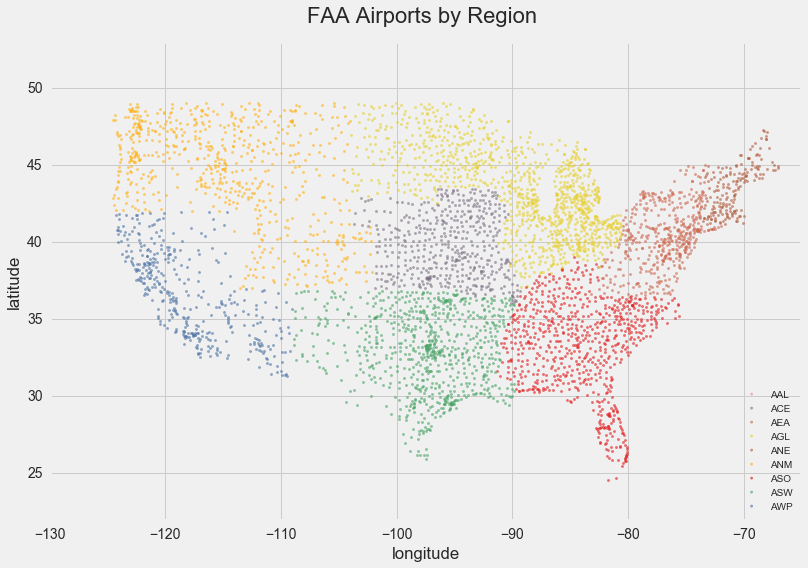

In [258]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

FAA_region = list(airports['FAA REGION'].unique())
FAA_colors = []
for i in range(0, 256, 256/(len(list(airports['FAA REGION'].unique())))):
    FAA_colors.append(cm.Set1(i))
FAA_dict = dict(zip(FAA_region, FAA_colors))

ASO = airports[airports['FAA REGION'] == 'ASO']
AWP = airports[airports['FAA REGION'] == 'AWP']
ASW = airports[airports['FAA REGION'] == 'ASW']
ACE = airports[airports['FAA REGION'] == 'ACE']
AEA = airports[airports['FAA REGION'] == 'AEA']
ANM = airports[airports['FAA REGION'] == 'ANM']
AGL = airports[airports['FAA REGION'] == 'AGL']
ANE = airports[airports['FAA REGION'] == 'ANE']
AAL = airports[airports['FAA REGION'] == 'AAL']
               

plt.scatter(AAL['long'], AAL['lat'], color = FAA_dict['AAL'], alpha = 0.6, label = 'AAL', s = 5)
plt.scatter(ACE['long'], ACE['lat'], color = FAA_dict['ACE'], alpha = 0.6, label = 'ACE', s = 5)
plt.scatter(AEA['long'], AEA['lat'], color = FAA_dict['AEA'], alpha = 0.6, label = 'AEA', s = 5)
plt.scatter(AGL['long'], AGL['lat'], color = FAA_dict['AGL'], alpha = 0.6, label = 'AGL', s = 5)
plt.scatter(ANE['long'], ANE['lat'], color = FAA_dict['ANE'], alpha = 0.6, label = 'ANE', s = 5)
plt.scatter(ANM['long'], ANM['lat'], color = FAA_dict['ANM'], alpha = 0.6, label = 'ANM', s = 5)
plt.scatter(ASO['long'], ASO['lat'], color = FAA_dict['ASO'], alpha = 0.6, label = 'ASO', s = 5)
plt.scatter(ASW['long'], ASW['lat'], color = FAA_dict['ASW'], alpha = 0.6, label = 'ASW', s = 5)
plt.scatter(AWP['long'], AWP['lat'], color = FAA_dict['AWP'], alpha = 0.6, label = 'AWP', s = 5)

# plt.scatter(fed_commercial['Longitude'], fed_commercial['Latitude'], color = 'red', alpha = 0.7, label = \
#             'federal/commercial')

plt.title('FAA Airports by Region ', fontsize = 22, y = 1.03)

# y label
plt.ylabel('latitude')

# x label
plt.xlabel('longitude')

# set the figure boundaries
plt.xlim([-130, -65])
plt.ylim([22, 53])
plt.grid(True)
plt.legend(loc='lower right', fontsize = 10)

plt.show()

In [259]:
airports['FAA REGION'].value_counts()

AGL    1074
ASW     769
ASO     745
ANM     649
ACE     473
AEA     468
AAL     406
AWP     397
ANE     183
Name: FAA REGION, dtype: int64

Highest density of airports by FAA region is in the Great Lakes (AGL), followed by the Southwest (ASW).

Poking around, we saw some county names missing:

In [260]:
airports[airports['COUNTY'] == '#NAME?']

Key LocID FAA REGION  COUNTY             CITY STATE        lat  \
1   5088.0   X64        ASO  #NAME?         PATILLAS    PR  17.982189   
2   2886.0   PSE        ASO  #NAME?            PONCE    PR  18.008306   
3   2879.0   VQS        ASO  #NAME?  ISLA DE VIEQUES    PR  18.134811   
4   2883.0   X63        ASO  #NAME?          HUMACAO    PR  18.138017   
5   2884.0   RVR        ASO  #NAME?            CEIBA    PR  18.245269   
6   2881.0   MAZ        ASO  #NAME?         MAYAGUEZ    PR  18.255694   
7   5087.0   X95        ASO  #NAME?          FAJARDO    PR  18.308010   
8   5086.0   CPX        ASO  #NAME?  ISLA DE CULEBRA    PR  18.313289   
10  2885.0   SJU        ASO  #NAME?         SAN JUAN    PR  18.439295   
11  2880.0   ABO        ASO  #NAME?          ARECIBO    PR  18.451111   
12  2882.0   SIG        ASO  #NAME?         SAN JUAN    PR  18.456791   
13  2887.0   BQN        ASO  #NAME?        AGUADILLA    PR  18.494861   

         long  public  
1  -66.019330       1  
2  -66.563028       1  
3  -65.493617       1  
4  -65.800718       1  
5  -65.643381       1  
6  -67.148472       1  
7  -65.661828       1  
8  -65.304324       1  
10 -66.002004       0  
11 -66.675556       1  
12 -66.098463       1  
13 -67.129444       1

They're all in Puerto Rico!  Let's just change county column to 'Puerto Rico.'

In [261]:
airports['COUNTY'] = airports['COUNTY'].apply(lambda x: x.replace('#NAME?', 'Puerto Rico'))

In [262]:
airports.shape

(5164, 9)

In [263]:
airports.head(1).T

0
Key                     3443
LocID                    STX
FAA REGION               ASO
COUNTY      -VIRGIN ISLANDS-
CITY           CHRISTIANSTED
STATE                     VI
lat                  17.7016
long                -64.8017
public                     1

Eventually, we'll dummify 'FAA REGION', and possibly some combination of 'COUNTY', 'CITY', and 'STATE.'  Intuition says major airports -- which are more likely to have delays, also by intuition -- are not always in the major city nearest to them, but rather in the greater metropolitan area (see: Newark International, serving New York, NY).  

In any case, we'll hold off dummifying until we merge dataframes since we may drop observations and columns would go to zero and need to be removed.

### Check out operations dataframe:

In [264]:
operations.head(2)

airport  year  departures for metric computation  \
0     ABQ  2004                              53971   
1     ABQ  2005                              51829   

   arrivals for metric computation  percent on-time gate departures  \
0                            53818                            0.803   
1                            51877                            0.814   

   percent on-time airport departures  percent on-time gate arrivals  \
0                              0.7809                         0.7921   
1                              0.7922                         0.8001   

   average_gate_departure_delay  average_taxi_out_time  \
0                         10.38                   9.89   
1                          9.60                   9.79   

   average taxi out delay  average airport departure delay  \
0                    2.43                             12.1   
1                    2.29                             11.2   

   average airborne delay  average taxi in delay  average block delay  \
0                    2.46                   0.83                 2.55   
1                    2.26                   0.89                 2.34   

   average gate arrival delay  
0                       10.87  
1                       10.24

In [265]:
operations.isnull().sum()

airport                               0
year                                  0
departures for metric computation     0
arrivals for metric computation       0
percent on-time gate departures       0
percent on-time airport departures    0
percent on-time gate arrivals         0
average_gate_departure_delay          0
average_taxi_out_time                 0
average taxi out delay                0
average airport departure delay       0
average airborne delay                0
average taxi in delay                 0
average block delay                   0
average gate arrival delay            0
dtype: int64

In [266]:
operations.columns = ['airport', 'year', 'dep for MC', 'arr for MC', 'perc ot gate dep', 'perc ot ap dep', \
                      'perc ot gate arr', 'avg gate dep del', 'avg taxi out time', 'avg taxi out del', \
                      'avg ap dep del', 'avg ab del', 'avg taxi in del', 'avg block del', 'avg gate arr del']

In [267]:
operations.dtypes

airport               object
year                   int64
dep for MC             int64
arr for MC             int64
perc ot gate dep     float64
perc ot ap dep       float64
perc ot gate arr     float64
avg gate dep del     float64
avg taxi out time    float64
avg taxi out del     float64
avg ap dep del       float64
avg ab del           float64
avg taxi in del      float64
avg block del        float64
avg gate arr del     float64
dtype: object

In [268]:
operations['year'].value_counts()

2014    77
2013    77
2012    77
2011    77
2010    77
2009    77
2008    77
2007    77
2006    75
2005    75
2004    75
Name: year, dtype: int64

In [269]:
set(operations['airport'].value_counts())

{8, 11}

In [270]:
operations['airport'].value_counts(ascending = True).head(5)

SMF     8
PSP     8
JFK    11
DAL    11
PBI    11
Name: airport, dtype: int64

SMF is in Sacramento, CA (missing 2004-06):

In [271]:
operations[operations['airport'] == 'SMF']

airport  year  dep for MC  arr for MC  perc ot gate dep  perc ot ap dep  \
756     SMF  2007       65686       65960            0.8025          0.7690   
757     SMF  2008       61470       61500            0.8067          0.7884   
758     SMF  2009       52731       52905            0.8401          0.8281   
759     SMF  2010       51516       51632            0.8209          0.8073   
760     SMF  2011       50574       50719            0.8265          0.7981   
761     SMF  2012       49016       49085            0.8505          0.8285   
762     SMF  2013       46868       47183            0.8242          0.7999   
763     SMF  2014       47618       47523            0.7861          0.7661   

     perc ot gate arr  avg gate dep del  avg taxi out time  avg taxi out del  \
756            0.7724             11.01              10.86              2.64   
757            0.7706             11.12              10.46              1.93   
758            0.8066              9.02               9.85              1.57   
759            0.7886              9.97               9.64              1.48   
760            0.8055              9.82              10.32              2.19   
761            0.8311              8.97              10.43              2.20   
762            0.8035              9.88              10.58              2.13   
763            0.7659             11.91              10.75              2.04   

     avg ap dep del  avg ab del  avg taxi in del  avg block del  \
756           12.95        2.54             1.12           2.59   
757           12.29        2.13             0.73           2.49   
758            9.75        1.88             0.65           1.75   
759           10.86        1.93             0.66           1.98   
760           11.36        1.86             0.83           2.01   
761           10.40        1.71             1.01           1.69   
762           11.29        1.87             0.74           1.64   
763           13.09        2.00             0.85           2.10   

     avg gate arr del  
756             12.17  
757             12.13  
758              9.87  
759             11.10  
760             10.41  
761              9.28  
762             10.47  
763             12.57

PSP is in Palm Springs, CA (missing 2004-06):

In [272]:
operations[operations['airport'] == 'PSP']

airport  year  dep for MC  arr for MC  perc ot gate dep  perc ot ap dep  \
616     PSP  2007       17764       17852            0.7411          0.7053   
617     PSP  2008       16005       16036            0.7683          0.7321   
618     PSP  2009       14802       14837            0.8128          0.7919   
619     PSP  2010       14769       14859            0.7944          0.7699   
620     PSP  2011       14458       14632            0.7738          0.7484   
621     PSP  2012       15601       15682            0.7692          0.7362   
622     PSP  2013       15346       15242            0.7754          0.7483   
623     PSP  2014       16231       16208            0.7632          0.7332   

     perc ot gate arr  avg gate dep del  avg taxi out time  avg taxi out del  \
616            0.7011             13.53              11.40              3.03   
617            0.7312             12.35              12.16              3.10   
618            0.7853             10.22              11.90              2.32   
619            0.7574             11.54              11.77              2.50   
620            0.7484             12.76              11.89              2.64   
621            0.7587             14.00              12.51              3.14   
622            0.7683             14.15              12.50              2.72   
623            0.7512             14.56              12.67              2.74   

     avg ap dep del  avg ab del  avg taxi in del  avg block del  \
616           15.56        2.48             1.00           3.52   
617           14.32        2.82             1.17           3.71   
618           11.52        2.67             0.68           2.88   
619           12.97        3.07             0.73           3.12   
620           14.33        3.35             0.77           3.30   
621           15.98        3.23             0.84           3.20   
622           15.76        2.89             0.95           2.91   
623           16.29        3.19             0.99           3.78   

     avg gate arr del  
616             15.67  
617             13.87  
618             10.95  
619             12.86  
620             13.57  
621             12.85  
622             12.66  
623             13.81

They're both missing observations from 2004-06; let's keep in for now.

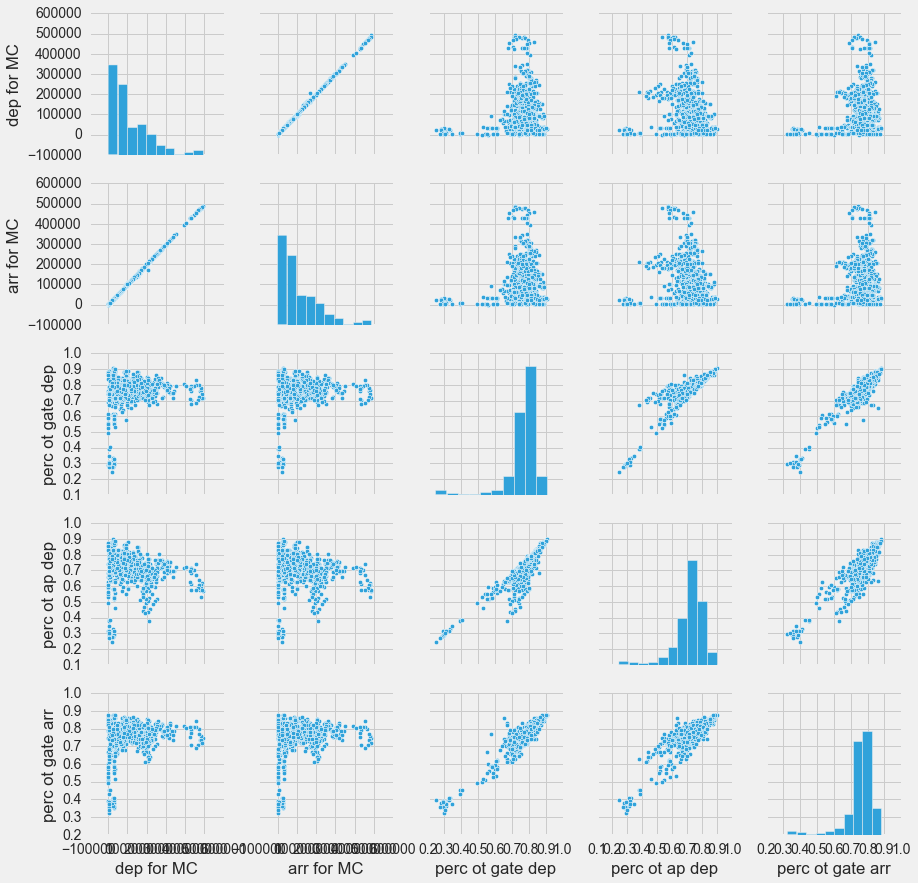

In [273]:
sns.pairplot(operations.ix[:,2:7])

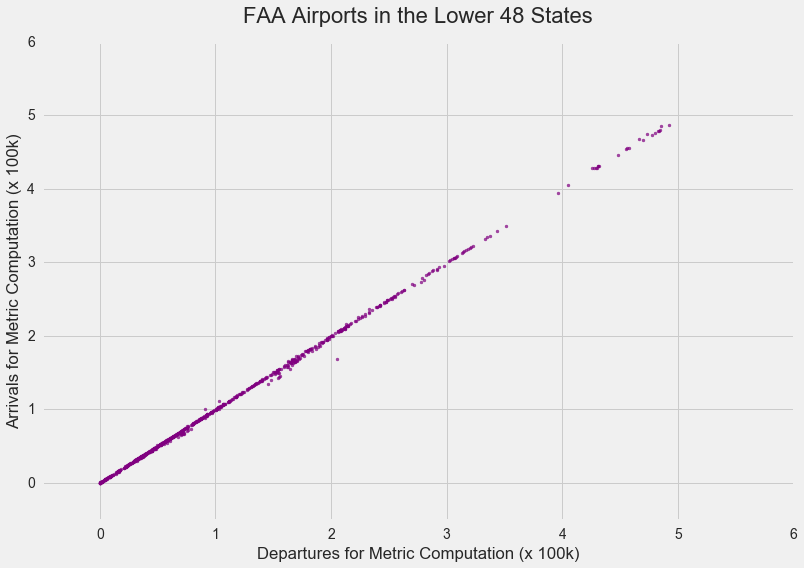

In [274]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(operations.ix[:,2]/100000, operations.ix[:,3]/100000, color = 'purple', alpha = 0.7, \
            label = 'public', s = 8)

plt.title('FAA Airports in the Lower 48 States', fontsize = 22, y = 1.03)

# y label
plt.ylabel('Arrivals for Metric Computation (x 100k)')

# x label
plt.xlabel('Departures for Metric Computation (x 100k)')

# set the figure boundaries
plt.xlim([-0.5, 6])
plt.ylim([-0.5, 6])
plt.grid(True)

plt.show()

Let's only keep one of these since correlation is nearly 1:

In [275]:
del operations['dep for MC']

In [276]:
operations.head(1)

airport  year  arr for MC  perc ot gate dep  perc ot ap dep  \
0     ABQ  2004       53818             0.803          0.7809   

   perc ot gate arr  avg gate dep del  avg taxi out time  avg taxi out del  \
0            0.7921             10.38               9.89              2.43   

   avg ap dep del  avg ab del  avg taxi in del  avg block del  \
0            12.1        2.46             0.83           2.55   

   avg gate arr del  
0             10.87

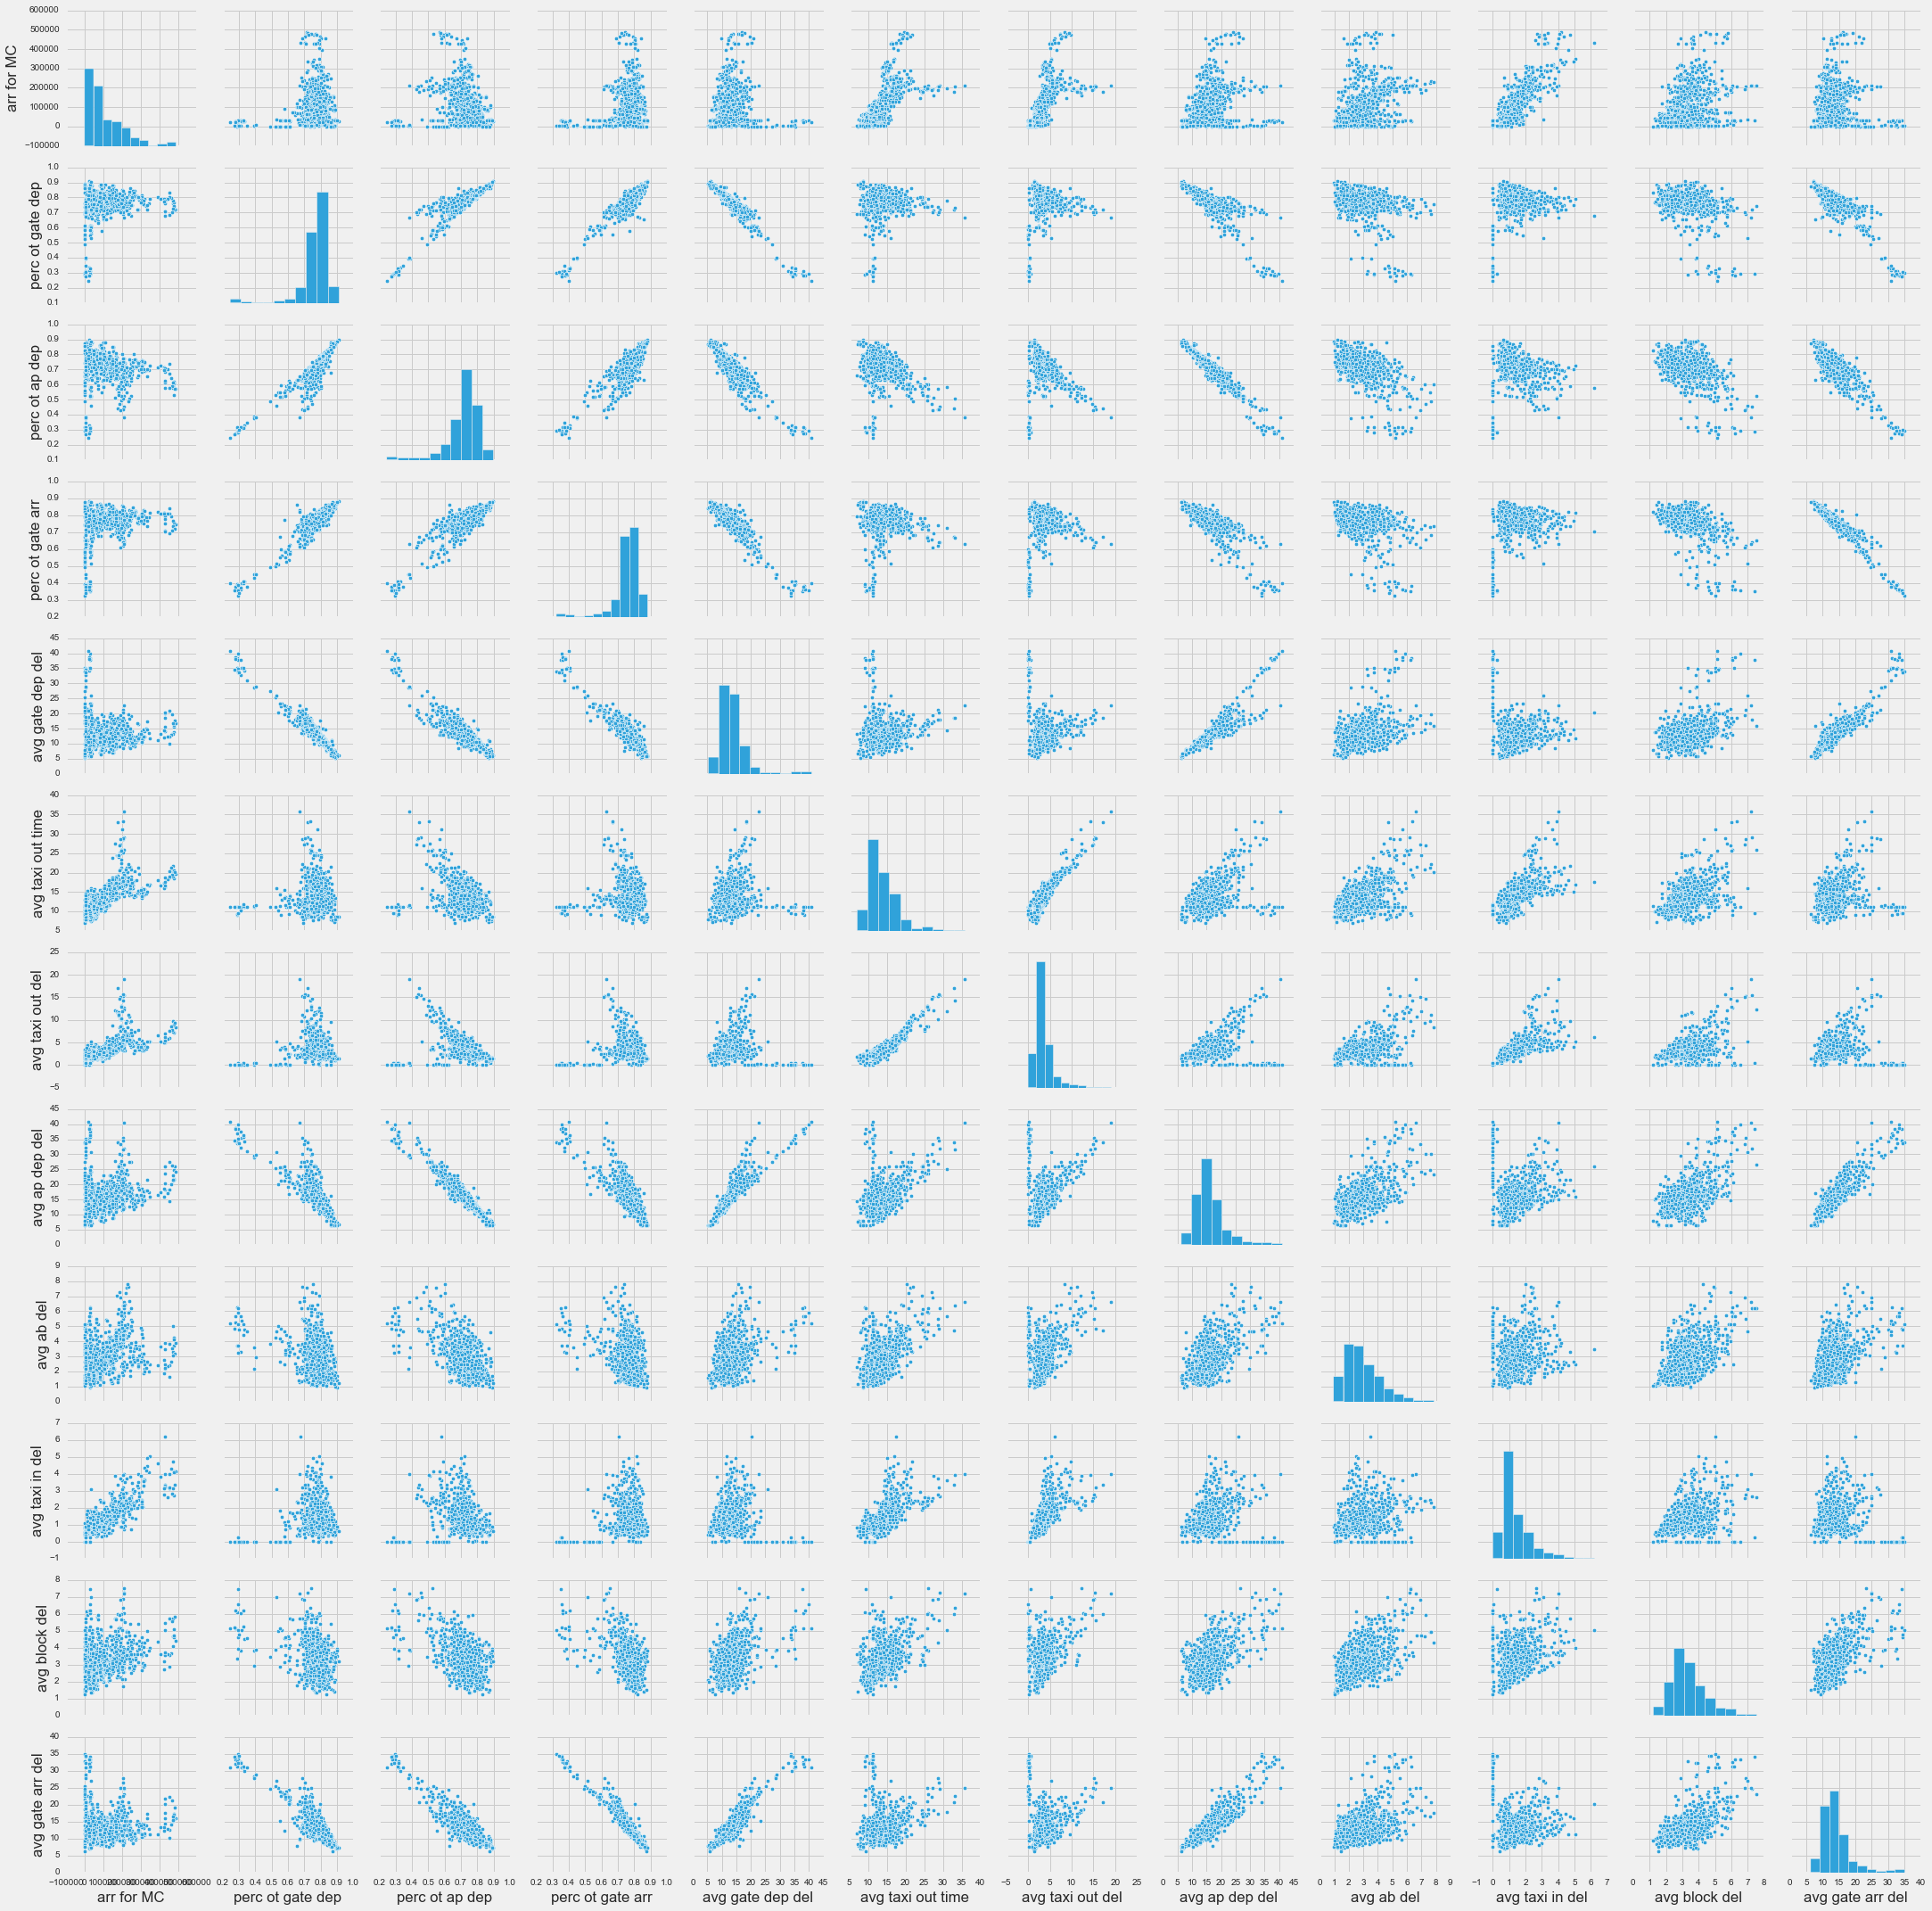

In [73]:
sns.pairplot(operations.ix[:,2:len(operations.columns) + 1])

None of these seem as near to 1:1 correlation; let's leave them all for now.

Let's see if we can merge cancel and operations dataframes on airport code:

In [277]:
len(cancel)

805

In [278]:
len(operations)

841

In [279]:
# the set return is codes present in cancel and not in operations
only_cancel = []
for code in cancel['Airport']:
    if code in list(operations['airport']):
        continue
    else:
        only_cancel.append(code)
print set(only_cancel)

set([])


In [280]:
# and vice versa
only_operations = []
for code in operations['airport']:
    if code in list(cancel['Airport']):
        continue
    else:
        only_operations.append(code)
print set(only_operations)

set(['TEB', 'VNY', 'GYY'])


TEB is in Teterborough, NJ:

In [281]:
operations[(operations['airport'] == 'TEB') & (operations['year'] == 2014)]

airport  year  arr for MC  perc ot gate dep  perc ot ap dep  \
807     TEB  2014       29781             0.327          0.3121   

     perc ot gate arr  avg gate dep del  avg taxi out time  avg taxi out del  \
807            0.4065             35.26              11.73              0.43   

     avg ap dep del  avg ab del  avg taxi in del  avg block del  \
807            36.4        5.15              0.0           6.19   

     avg gate arr del  
807             31.38

VNY is in Van Nuys, CA:

In [282]:
operations[(operations['airport'] == 'VNY') & (operations['year'] == 2014)]

airport  year  arr for MC  perc ot gate dep  perc ot ap dep  \
840     VNY  2014        7573            0.4014          0.3841   

     perc ot gate arr  avg gate dep del  avg taxi out time  avg taxi out del  \
840            0.4507             28.87               11.7               0.4   

     avg ap dep del  avg ab del  avg taxi in del  avg block del  \
840           29.96        2.92              0.0           3.89   

     avg gate arr del  
840             28.97

GYY is in Gary, IN:

In [283]:
operations[(operations['airport'] == 'GYY') & (operations['year'] == 2014)]

airport  year  arr for MC  perc ot gate dep  perc ot ap dep  \
252     GYY  2014         752            0.5857           0.561   

     perc ot gate arr  avg gate dep del  avg taxi out time  avg taxi out del  \
252            0.5505             22.02              11.57              0.33   

     avg ap dep del  avg ab del  avg taxi in del  avg block del  \
252           22.93        3.12              0.0           3.59   

     avg gate arr del  
252             23.08

That's nice, now let's get rid of them:

In [284]:
operations = operations[operations['airport'] != 'TEB']
operations = operations[operations['airport'] != 'VNY']
operations = operations[operations['airport'] != 'GYY']

In [285]:
len(operations)

808

In [286]:
len(cancel)

805

Hm, still 3 off... let's see what's going on:

In [287]:
cancel['Airport'].value_counts(ascending = True).head(5)

RFD     6
OXR     7
JFK    11
DAL    11
PBI    11
Name: Airport, dtype: int64

In [288]:
operations['airport'].value_counts(ascending = True).head(5)

SMF     8
PSP     8
JFK    11
SLC    11
DAL    11
Name: airport, dtype: int64

In [289]:
cancel[cancel['Airport'] == 'RFD'][['Airport', 'Year']].T

634   635   636   637   638   639
Airport   RFD   RFD   RFD   RFD   RFD   RFD
Year     2006  2007  2008  2011  2012  2013

In [290]:
operations[operations['airport'] == 'RFD'][['airport', 'year']].T

646   647   648   649   650   651   652   653   654   655   656
airport   RFD   RFD   RFD   RFD   RFD   RFD   RFD   RFD   RFD   RFD   RFD
year     2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014

In [291]:
operations = operations.drop(operations.index[[646, 647, 651, 652, 656]])

In [292]:
cancel[cancel['Airport'] == 'OXR'][['Airport', 'Year']].T

539   540   541   542   543   544   545
Airport   OXR   OXR   OXR   OXR   OXR   OXR   OXR
Year     2004  2005  2006  2007  2008  2009  2010

In [293]:
operations[operations['airport'] == 'OXR'][['airport', 'year']].T

550   551   552   553   554   555   556   557   558   559   560
airport   OXR   OXR   OXR   OXR   OXR   OXR   OXR   OXR   OXR   OXR   OXR
year     2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014

In [294]:
operations = operations.drop(operations.index[[557, 558, 559, 560]])

In [295]:
cancel[cancel['Airport'] == 'SMF'][['Airport', 'Year']].T

739   740   741   742   743   744   745   746   747   748   749
Airport   SMF   SMF   SMF   SMF   SMF   SMF   SMF   SMF   SMF   SMF   SMF
Year     2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014

In [296]:
operations[operations['airport'] == 'SMF'][['airport', 'year']].T

756   757   758   759   760   761   762   763
airport   SMF   SMF   SMF   SMF   SMF   SMF   SMF   SMF
year     2007  2008  2009  2010  2011  2012  2013  2014

In [297]:
cancel = cancel.drop(cancel.index[[739, 740, 741]])

In [298]:
cancel[cancel['Airport'] == 'PSP'][['Airport', 'Year']].T

601   602   603   604   605   606   607   608   609   610   611
Airport   PSP   PSP   PSP   PSP   PSP   PSP   PSP   PSP   PSP   PSP   PSP
Year     2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014

In [299]:
operations[operations['airport'] == 'PSP'][['airport', 'year']].T

616   617   618   619   620   621   622   623
airport   PSP   PSP   PSP   PSP   PSP   PSP   PSP   PSP
year     2007  2008  2009  2010  2011  2012  2013  2014

In [300]:
cancel = cancel.drop(cancel.index[[601, 602, 603]])

In [301]:
len(operations)

799

In [302]:
len(cancel)

799

Ok hopefully we're good now!  Merging to follow...

## Project aim:

We will try to figure out which features are most helpful in predicting airport departure delays and consider approaches to fixing them.

### Create a PostgreSQL database 

In [257]:
engine = create_engine('postgresql://@localhost:5432/airportdb')

airports.to_sql('aps', engine)
cancel.to_sql('cancels', engine)
operations.to_sql('ops', engine)

In [258]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [259]:
%%sql 
postgresql://@localhost:5432/airportdb

u'Connected: @airportdb'

In [260]:
%%sql
SELECT * FROM aps LIMIT 2;

2 rows affected.


[(0L, 3443.0, u'STX', u'ASO', u'-VIRGIN ISLANDS-', u'CHRISTIANSTED', u'VI', 17.701556, -64.801722, 1L),
 (1L, 5088.0, u'X64', u'ASO', u'Puerto Rico', u'PATILLAS', u'PR', 17.982189, -66.01933, 1L)]

In [261]:
%%sql
SELECT * FROM cancels LIMIT 2;

2 rows affected.


[(0L, u'ABQ', 2004.0, 235.0, 71.0, 46.0),
 (1L, u'ABQ', 2005.0, 190.0, 61.0, 33.0)]

In [262]:
%%sql
SELECT * FROM ops LIMIT 2;

2 rows affected.


[(0L, u'ABQ', 2004L, 53818L, 0.803, 0.7809, 0.7921, 10.38, 9.89, 2.43, 12.1, 2.46, 0.83, 2.55, 10.87),
 (1L, u'ABQ', 2005L, 51877L, 0.814, 0.7922, 0.8001, 9.6, 9.79, 2.29, 11.2, 2.26, 0.89, 2.34, 10.24)]

In [271]:
# airports = pd.read_sql("aps", engine);
# cancel = pd.read_sql("cancels", engine);
# operations = pd.read_sql("ops", engine)

In [272]:
# del airports['index']
# del cancel['index']
# del operations['index']

#### What are the risks and assumptions of our data? 

* don't know units for any time measurement
* don't know what a 'block' delay is
* don't know what 'Key' is
* don't know how data were collected (every airport?  every day?  who measured the delays?)
* assuming data from 2004-14 is helpful in predicting similar targets in 2016

### Exploratory Data Analysis

#### Plot and Describe the Data

In [303]:
airports.head(1)

Key LocID FAA REGION            COUNTY           CITY STATE        lat  \
0  3443.0   STX        ASO  -VIRGIN ISLANDS-  CHRISTIANSTED    VI  17.701556   

        long  public  
0 -64.801722       1

In [304]:
cancel.head(1)

Airport    Year  arr cancel  dep divers  arr divers
0     ABQ  2004.0       235.0        71.0        46.0

In [305]:
operations.head(1)

airport  year  arr for MC  perc ot gate dep  perc ot ap dep  \
0     ABQ  2004       53818             0.803          0.7809   

   perc ot gate arr  avg gate dep del  avg taxi out time  avg taxi out del  \
0            0.7921             10.38               9.89              2.43   

   avg ap dep del  avg ab del  avg taxi in del  avg block del  \
0            12.1        2.46             0.83           2.55   

   avg gate arr del  
0             10.87

In [306]:
big_airport = pd.merge(operations, cancel, left_on=['airport', 'year'], right_on=['Airport','Year'], how='outer')
big_airport = big_airport.merge(airports, left_on = 'Airport', right_on = 'LocID', how = 'left')

In [307]:
del big_airport['Airport']
del big_airport['LocID']
del big_airport['Year']

In [308]:
big_airport.shape

(808, 25)

In [309]:
big_airport.isnull().sum()

airport              9
year                 9
arr for MC           9
perc ot gate dep     9
perc ot ap dep       9
perc ot gate arr     9
avg gate dep del     9
avg taxi out time    9
avg taxi out del     9
avg ap dep del       9
avg ab del           9
avg taxi in del      9
avg block del        9
avg gate arr del     9
arr cancel           9
dep divers           9
arr divers           9
Key                  9
FAA REGION           9
COUNTY               9
CITY                 9
STATE                9
lat                  9
long                 9
public               9
dtype: int64

Take out those 9 lines:

In [310]:
big_airport.dropna(axis = 0, inplace = True)

In [311]:
big_airport.isnull().sum()

airport              0
year                 0
arr for MC           0
perc ot gate dep     0
perc ot ap dep       0
perc ot gate arr     0
avg gate dep del     0
avg taxi out time    0
avg taxi out del     0
avg ap dep del       0
avg ab del           0
avg taxi in del      0
avg block del        0
avg gate arr del     0
arr cancel           0
dep divers           0
arr divers           0
Key                  0
FAA REGION           0
COUNTY               0
CITY                 0
STATE                0
lat                  0
long                 0
public               0
dtype: int64

We're good!  Merge complete.  Let's check to see what kind of duplicate city and county entries there are (i.e., same name but not referring to same geographic location).  There should be no more than 11 observations per unique airport, since data are from the year range 2004-2014.

In [312]:
big_airport['CITY'].value_counts().head(5)

NEW YORK             33
HOUSTON              22
WASHINGTON           22
CHICAGO              22
DALLAS-FORT WORTH    11
Name: CITY, dtype: int64

In [313]:
big_airport[big_airport['CITY'] == 'NEW YORK']['airport'].unique()  ## these are all in NYC

array(['ISP', 'JFK', 'LGA'], dtype=object)

In [314]:
big_airport[big_airport['CITY'] == 'HOUSTON']['airport'].unique()  ## these are both in houston

array(['HOU', 'IAH'], dtype=object)

In [315]:
big_airport[big_airport['CITY'] == 'WASHINGTON']['airport'].unique() ## these are both in D.C.

array(['DCA', 'IAD'], dtype=object)

In [316]:
big_airport[big_airport['CITY'] == 'CHICAGO']['airport'].unique() ## these are both in Chicago

array(['MDW', 'ORD'], dtype=object)

Now, let's check counties:

In [317]:
big_airport['COUNTY'].value_counts().head(10)

ORANGE          33
LOS ANGELES     33
JEFFERSON       33
COOK            22
QUEENS          22
HILLSBOROUGH    22
SUFFOLK         22
HARRIS          22
DALLAS          11
KING            11
Name: COUNTY, dtype: int64

In [318]:
big_airport[big_airport['COUNTY'] == 'ORANGE'][['airport', 'year', 'FAA REGION', 'COUNTY', 'CITY', 'STATE']]

airport    year FAA REGION  COUNTY       CITY STATE
396     MCO  2004.0        ASO  ORANGE    ORLANDO    FL
397     MCO  2005.0        ASO  ORANGE    ORLANDO    FL
398     MCO  2006.0        ASO  ORANGE    ORLANDO    FL
399     MCO  2007.0        ASO  ORANGE    ORLANDO    FL
400     MCO  2008.0        ASO  ORANGE    ORLANDO    FL
401     MCO  2009.0        ASO  ORANGE    ORLANDO    FL
402     MCO  2010.0        ASO  ORANGE    ORLANDO    FL
403     MCO  2011.0        ASO  ORANGE    ORLANDO    FL
404     MCO  2012.0        ASO  ORANGE    ORLANDO    FL
405     MCO  2013.0        ASO  ORANGE    ORLANDO    FL
406     MCO  2014.0        ASO  ORANGE    ORLANDO    FL
744     SNA  2004.0        AWP  ORANGE  SANTA ANA    CA
745     SNA  2005.0        AWP  ORANGE  SANTA ANA    CA
746     SNA  2006.0        AWP  ORANGE  SANTA ANA    CA
747     SNA  2007.0        AWP  ORANGE  SANTA ANA    CA
748     SNA  2008.0        AWP  ORANGE  SANTA ANA    CA
749     SNA  2009.0        AWP  ORANGE  SANTA ANA    CA
750     SNA  2010.0        AWP  ORANGE  SANTA ANA    CA
751     SNA  2011.0        AWP  ORANGE  SANTA ANA    CA
752     SNA  2012.0        AWP  ORANGE  SANTA ANA    CA
753     SNA  2013.0        AWP  ORANGE  SANTA ANA    CA
754     SNA  2014.0        AWP  ORANGE  SANTA ANA    CA
766     SWF  2004.0        AEA  ORANGE   NEWBURGH    NY
767     SWF  2005.0        AEA  ORANGE   NEWBURGH    NY
768     SWF  2006.0        AEA  ORANGE   NEWBURGH    NY
769     SWF  2007.0        AEA  ORANGE   NEWBURGH    NY
770     SWF  2008.0        AEA  ORANGE   NEWBURGH    NY
771     SWF  2009.0        AEA  ORANGE   NEWBURGH    NY
772     SWF  2010.0        AEA  ORANGE   NEWBURGH    NY
773     SWF  2011.0        AEA  ORANGE   NEWBURGH    NY
774     SWF  2012.0        AEA  ORANGE   NEWBURGH    NY
775     SWF  2013.0        AEA  ORANGE   NEWBURGH    NY
776     SWF  2014.0        AEA  ORANGE   NEWBURGH    NY

In [319]:
big_airport['COUNTY'].loc[396:406] = 'ORANGE FL'
big_airport['COUNTY'].loc[744:754] = 'ORANGE CA'
big_airport['COUNTY'].loc[766:776] = 'ORANGE NY'

In [320]:
big_airport[big_airport['COUNTY'] == 'LOS ANGELES'][['airport', 'year', 'FAA REGION', 'COUNTY', 'CITY', 'STATE']]

airport    year FAA REGION       COUNTY         CITY STATE
99      BUR  2004.0        AWP  LOS ANGELES      BURBANK    CA
100     BUR  2005.0        AWP  LOS ANGELES      BURBANK    CA
101     BUR  2006.0        AWP  LOS ANGELES      BURBANK    CA
102     BUR  2007.0        AWP  LOS ANGELES      BURBANK    CA
103     BUR  2008.0        AWP  LOS ANGELES      BURBANK    CA
104     BUR  2009.0        AWP  LOS ANGELES      BURBANK    CA
105     BUR  2010.0        AWP  LOS ANGELES      BURBANK    CA
106     BUR  2011.0        AWP  LOS ANGELES      BURBANK    CA
107     BUR  2012.0        AWP  LOS ANGELES      BURBANK    CA
108     BUR  2013.0        AWP  LOS ANGELES      BURBANK    CA
109     BUR  2014.0        AWP  LOS ANGELES      BURBANK    CA
352     LAX  2004.0        AWP  LOS ANGELES  LOS ANGELES    CA
353     LAX  2005.0        AWP  LOS ANGELES  LOS ANGELES    CA
354     LAX  2006.0        AWP  LOS ANGELES  LOS ANGELES    CA
355     LAX  2007.0        AWP  LOS ANGELES  LOS ANGELES    CA
356     LAX  2008.0        AWP  LOS ANGELES  LOS ANGELES    CA
357     LAX  2009.0        AWP  LOS ANGELES  LOS ANGELES    CA
358     LAX  2010.0        AWP  LOS ANGELES  LOS ANGELES    CA
359     LAX  2011.0        AWP  LOS ANGELES  LOS ANGELES    CA
360     LAX  2012.0        AWP  LOS ANGELES  LOS ANGELES    CA
361     LAX  2013.0        AWP  LOS ANGELES  LOS ANGELES    CA
362     LAX  2014.0        AWP  LOS ANGELES  LOS ANGELES    CA
374     LGB  2004.0        AWP  LOS ANGELES   LONG BEACH    CA
375     LGB  2005.0        AWP  LOS ANGELES   LONG BEACH    CA
376     LGB  2006.0        AWP  LOS ANGELES   LONG BEACH    CA
377     LGB  2007.0        AWP  LOS ANGELES   LONG BEACH    CA
378     LGB  2008.0        AWP  LOS ANGELES   LONG BEACH    CA
379     LGB  2009.0        AWP  LOS ANGELES   LONG BEACH    CA
380     LGB  2010.0        AWP  LOS ANGELES   LONG BEACH    CA
381     LGB  2011.0        AWP  LOS ANGELES   LONG BEACH    CA
382     LGB  2012.0        AWP  LOS ANGELES   LONG BEACH    CA
383     LGB  2013.0        AWP  LOS ANGELES   LONG BEACH    CA
384     LGB  2014.0        AWP  LOS ANGELES   LONG BEACH    CA

In [321]:
big_airport[big_airport['COUNTY'] == 'JEFFERSON'][['airport', 'year', 'FAA REGION', 'COUNTY', 'CITY', 'STATE']]

airport    year FAA REGION     COUNTY         CITY STATE
55      BHM  2004.0        ASO  JEFFERSON   BIRMINGHAM    AL
56      BHM  2005.0        ASO  JEFFERSON   BIRMINGHAM    AL
57      BHM  2006.0        ASO  JEFFERSON   BIRMINGHAM    AL
58      BHM  2007.0        ASO  JEFFERSON   BIRMINGHAM    AL
59      BHM  2008.0        ASO  JEFFERSON   BIRMINGHAM    AL
60      BHM  2009.0        ASO  JEFFERSON   BIRMINGHAM    AL
61      BHM  2010.0        ASO  JEFFERSON   BIRMINGHAM    AL
62      BHM  2011.0        ASO  JEFFERSON   BIRMINGHAM    AL
63      BHM  2012.0        ASO  JEFFERSON   BIRMINGHAM    AL
64      BHM  2013.0        ASO  JEFFERSON   BIRMINGHAM    AL
65      BHM  2014.0        ASO  JEFFERSON   BIRMINGHAM    AL
473     MSY  2004.0        ASW  JEFFERSON  NEW ORLEANS    LA
474     MSY  2005.0        ASW  JEFFERSON  NEW ORLEANS    LA
475     MSY  2006.0        ASW  JEFFERSON  NEW ORLEANS    LA
476     MSY  2007.0        ASW  JEFFERSON  NEW ORLEANS    LA
477     MSY  2008.0        ASW  JEFFERSON  NEW ORLEANS    LA
478     MSY  2009.0        ASW  JEFFERSON  NEW ORLEANS    LA
479     MSY  2010.0        ASW  JEFFERSON  NEW ORLEANS    LA
480     MSY  2011.0        ASW  JEFFERSON  NEW ORLEANS    LA
481     MSY  2012.0        ASW  JEFFERSON  NEW ORLEANS    LA
482     MSY  2013.0        ASW  JEFFERSON  NEW ORLEANS    LA
483     MSY  2014.0        ASW  JEFFERSON  NEW ORLEANS    LA
670     SDF  2004.0        ASO  JEFFERSON   LOUISVILLE    KY
671     SDF  2005.0        ASO  JEFFERSON   LOUISVILLE    KY
672     SDF  2006.0        ASO  JEFFERSON   LOUISVILLE    KY
673     SDF  2007.0        ASO  JEFFERSON   LOUISVILLE    KY
674     SDF  2008.0        ASO  JEFFERSON   LOUISVILLE    KY
675     SDF  2009.0        ASO  JEFFERSON   LOUISVILLE    KY
676     SDF  2010.0        ASO  JEFFERSON   LOUISVILLE    KY
677     SDF  2011.0        ASO  JEFFERSON   LOUISVILLE    KY
678     SDF  2012.0        ASO  JEFFERSON   LOUISVILLE    KY
679     SDF  2013.0        ASO  JEFFERSON   LOUISVILLE    KY
680     SDF  2014.0        ASO  JEFFERSON   LOUISVILLE    KY

In [322]:
big_airport['COUNTY'].loc[55:65] = 'JEFFERSON AL'
big_airport['COUNTY'].loc[473:483] = 'JEFFERSON LA'
big_airport['COUNTY'].loc[670:680] = 'JEFFERSON KY'

In [323]:
big_airport[big_airport['COUNTY'] == 'COOK'][['airport', 'year', 'FAA REGION', 'COUNTY', 'CITY', 'STATE']]

airport    year FAA REGION COUNTY     CITY STATE
407     MDW  2004.0        AGL   COOK  CHICAGO    IL
408     MDW  2005.0        AGL   COOK  CHICAGO    IL
409     MDW  2006.0        AGL   COOK  CHICAGO    IL
410     MDW  2007.0        AGL   COOK  CHICAGO    IL
411     MDW  2008.0        AGL   COOK  CHICAGO    IL
412     MDW  2009.0        AGL   COOK  CHICAGO    IL
413     MDW  2010.0        AGL   COOK  CHICAGO    IL
414     MDW  2011.0        AGL   COOK  CHICAGO    IL
415     MDW  2012.0        AGL   COOK  CHICAGO    IL
416     MDW  2013.0        AGL   COOK  CHICAGO    IL
417     MDW  2014.0        AGL   COOK  CHICAGO    IL
528     ORD  2004.0        AGL   COOK  CHICAGO    IL
529     ORD  2005.0        AGL   COOK  CHICAGO    IL
530     ORD  2006.0        AGL   COOK  CHICAGO    IL
531     ORD  2007.0        AGL   COOK  CHICAGO    IL
532     ORD  2008.0        AGL   COOK  CHICAGO    IL
533     ORD  2009.0        AGL   COOK  CHICAGO    IL
534     ORD  2010.0        AGL   COOK  CHICAGO    IL
535     ORD  2011.0        AGL   COOK  CHICAGO    IL
536     ORD  2012.0        AGL   COOK  CHICAGO    IL
537     ORD  2013.0        AGL   COOK  CHICAGO    IL
538     ORD  2014.0        AGL   COOK  CHICAGO    IL

In [324]:
big_airport[big_airport['COUNTY'] == 'QUEENS'][['airport', 'year', 'FAA REGION', 'COUNTY', 'CITY', 'STATE']]

airport    year FAA REGION  COUNTY      CITY STATE
330     JFK  2004.0        AEA  QUEENS  NEW YORK    NY
331     JFK  2005.0        AEA  QUEENS  NEW YORK    NY
332     JFK  2006.0        AEA  QUEENS  NEW YORK    NY
333     JFK  2007.0        AEA  QUEENS  NEW YORK    NY
334     JFK  2008.0        AEA  QUEENS  NEW YORK    NY
335     JFK  2009.0        AEA  QUEENS  NEW YORK    NY
336     JFK  2010.0        AEA  QUEENS  NEW YORK    NY
337     JFK  2011.0        AEA  QUEENS  NEW YORK    NY
338     JFK  2012.0        AEA  QUEENS  NEW YORK    NY
339     JFK  2013.0        AEA  QUEENS  NEW YORK    NY
340     JFK  2014.0        AEA  QUEENS  NEW YORK    NY
363     LGA  2004.0        AEA  QUEENS  NEW YORK    NY
364     LGA  2005.0        AEA  QUEENS  NEW YORK    NY
365     LGA  2006.0        AEA  QUEENS  NEW YORK    NY
366     LGA  2007.0        AEA  QUEENS  NEW YORK    NY
367     LGA  2008.0        AEA  QUEENS  NEW YORK    NY
368     LGA  2009.0        AEA  QUEENS  NEW YORK    NY
369     LGA  2010.0        AEA  QUEENS  NEW YORK    NY
370     LGA  2011.0        AEA  QUEENS  NEW YORK    NY
371     LGA  2012.0        AEA  QUEENS  NEW YORK    NY
372     LGA  2013.0        AEA  QUEENS  NEW YORK    NY
373     LGA  2014.0        AEA  QUEENS  NEW YORK    NY

In [325]:
big_airport[big_airport['COUNTY'] == 'HILLSBOROUGH'][['airport', 'year', 'FAA REGION', 'COUNTY', 'CITY', 'STATE']]

airport    year FAA REGION        COUNTY        CITY STATE
429     MHT  2004.0        ANE  HILLSBOROUGH  MANCHESTER    NH
430     MHT  2005.0        ANE  HILLSBOROUGH  MANCHESTER    NH
431     MHT  2006.0        ANE  HILLSBOROUGH  MANCHESTER    NH
432     MHT  2007.0        ANE  HILLSBOROUGH  MANCHESTER    NH
433     MHT  2008.0        ANE  HILLSBOROUGH  MANCHESTER    NH
434     MHT  2009.0        ANE  HILLSBOROUGH  MANCHESTER    NH
435     MHT  2010.0        ANE  HILLSBOROUGH  MANCHESTER    NH
436     MHT  2011.0        ANE  HILLSBOROUGH  MANCHESTER    NH
437     MHT  2012.0        ANE  HILLSBOROUGH  MANCHESTER    NH
438     MHT  2013.0        ANE  HILLSBOROUGH  MANCHESTER    NH
439     MHT  2014.0        ANE  HILLSBOROUGH  MANCHESTER    NH
777     TPA  2004.0        ASO  HILLSBOROUGH       TAMPA    FL
778     TPA  2005.0        ASO  HILLSBOROUGH       TAMPA    FL
779     TPA  2006.0        ASO  HILLSBOROUGH       TAMPA    FL
780     TPA  2007.0        ASO  HILLSBOROUGH       TAMPA    FL
781     TPA  2008.0        ASO  HILLSBOROUGH       TAMPA    FL
782     TPA  2009.0        ASO  HILLSBOROUGH       TAMPA    FL
783     TPA  2010.0        ASO  HILLSBOROUGH       TAMPA    FL
784     TPA  2011.0        ASO  HILLSBOROUGH       TAMPA    FL
785     TPA  2012.0        ASO  HILLSBOROUGH       TAMPA    FL
786     TPA  2013.0        ASO  HILLSBOROUGH       TAMPA    FL
787     TPA  2014.0        ASO  HILLSBOROUGH       TAMPA    FL

In [326]:
big_airport['COUNTY'].loc[429:439] = 'HILLSBOROUGH NH'
big_airport['COUNTY'].loc[777:787] = 'HILLSBOROUGH FL'

In [327]:
big_airport[big_airport['COUNTY'] == 'SUFFOLK'][['airport', 'year', 'FAA REGION', 'COUNTY', 'CITY', 'STATE']]

airport    year FAA REGION   COUNTY      CITY STATE
77      BOS  2004.0        ANE  SUFFOLK    BOSTON    MA
78      BOS  2005.0        ANE  SUFFOLK    BOSTON    MA
79      BOS  2006.0        ANE  SUFFOLK    BOSTON    MA
80      BOS  2007.0        ANE  SUFFOLK    BOSTON    MA
81      BOS  2008.0        ANE  SUFFOLK    BOSTON    MA
82      BOS  2009.0        ANE  SUFFOLK    BOSTON    MA
83      BOS  2010.0        ANE  SUFFOLK    BOSTON    MA
84      BOS  2011.0        ANE  SUFFOLK    BOSTON    MA
85      BOS  2012.0        ANE  SUFFOLK    BOSTON    MA
86      BOS  2013.0        ANE  SUFFOLK    BOSTON    MA
87      BOS  2014.0        ANE  SUFFOLK    BOSTON    MA
308     ISP  2004.0        AEA  SUFFOLK  NEW YORK    NY
309     ISP  2005.0        AEA  SUFFOLK  NEW YORK    NY
310     ISP  2006.0        AEA  SUFFOLK  NEW YORK    NY
311     ISP  2007.0        AEA  SUFFOLK  NEW YORK    NY
312     ISP  2008.0        AEA  SUFFOLK  NEW YORK    NY
313     ISP  2009.0        AEA  SUFFOLK  NEW YORK    NY
314     ISP  2010.0        AEA  SUFFOLK  NEW YORK    NY
315     ISP  2011.0        AEA  SUFFOLK  NEW YORK    NY
316     ISP  2012.0        AEA  SUFFOLK  NEW YORK    NY
317     ISP  2013.0        AEA  SUFFOLK  NEW YORK    NY
318     ISP  2014.0        AEA  SUFFOLK  NEW YORK    NY

In [328]:
big_airport['COUNTY'].loc[77:87] = 'SUFFOLK MA'
big_airport['COUNTY'].loc[308:318] = 'SUFFOLK NY'

In [329]:
big_airport[big_airport['COUNTY'] == 'HARRIS'][['airport', 'year', 'FAA REGION', 'COUNTY', 'CITY', 'STATE']]

airport    year FAA REGION  COUNTY     CITY STATE
253     HOU  2004.0        ASW  HARRIS  HOUSTON    TX
254     HOU  2005.0        ASW  HARRIS  HOUSTON    TX
255     HOU  2006.0        ASW  HARRIS  HOUSTON    TX
256     HOU  2007.0        ASW  HARRIS  HOUSTON    TX
257     HOU  2008.0        ASW  HARRIS  HOUSTON    TX
258     HOU  2009.0        ASW  HARRIS  HOUSTON    TX
259     HOU  2010.0        ASW  HARRIS  HOUSTON    TX
260     HOU  2011.0        ASW  HARRIS  HOUSTON    TX
261     HOU  2012.0        ASW  HARRIS  HOUSTON    TX
262     HOU  2013.0        ASW  HARRIS  HOUSTON    TX
263     HOU  2014.0        ASW  HARRIS  HOUSTON    TX
286     IAH  2004.0        ASW  HARRIS  HOUSTON    TX
287     IAH  2005.0        ASW  HARRIS  HOUSTON    TX
288     IAH  2006.0        ASW  HARRIS  HOUSTON    TX
289     IAH  2007.0        ASW  HARRIS  HOUSTON    TX
290     IAH  2008.0        ASW  HARRIS  HOUSTON    TX
291     IAH  2009.0        ASW  HARRIS  HOUSTON    TX
292     IAH  2010.0        ASW  HARRIS  HOUSTON    TX
293     IAH  2011.0        ASW  HARRIS  HOUSTON    TX
294     IAH  2012.0        ASW  HARRIS  HOUSTON    TX
295     IAH  2013.0        ASW  HARRIS  HOUSTON    TX
296     IAH  2014.0        ASW  HARRIS  HOUSTON    TX

We know that Newark International Airport probably has a lot of delays, like other NYC airports.  To reflect the metropolitan area it serves, we could alter its geographic info.  Let's not and see what happens.

In [330]:
big_airport['COUNTY'].value_counts().head(10)

LOS ANGELES      33
COOK             22
QUEENS           22
HARRIS           22
FULTON           11
ESSEX            11
MULTNOMAH        11
DALLAS           11
ST LOUIS CITY    11
SAN DIEGO        11
Name: COUNTY, dtype: int64

The 'county count' column indicates how many other airports are in the observation's county:

In [331]:
county_count = []
for i in big_airport['COUNTY']:
    if i == 'LOS ANGELES':
        county_count.append(2)
    elif i in ['COOK', 'QUEENS', 'HARRIS']:
        county_count.append(1)
    else:
        county_count.append(0)
big_airport['county count'] = county_count
del big_airport['COUNTY']

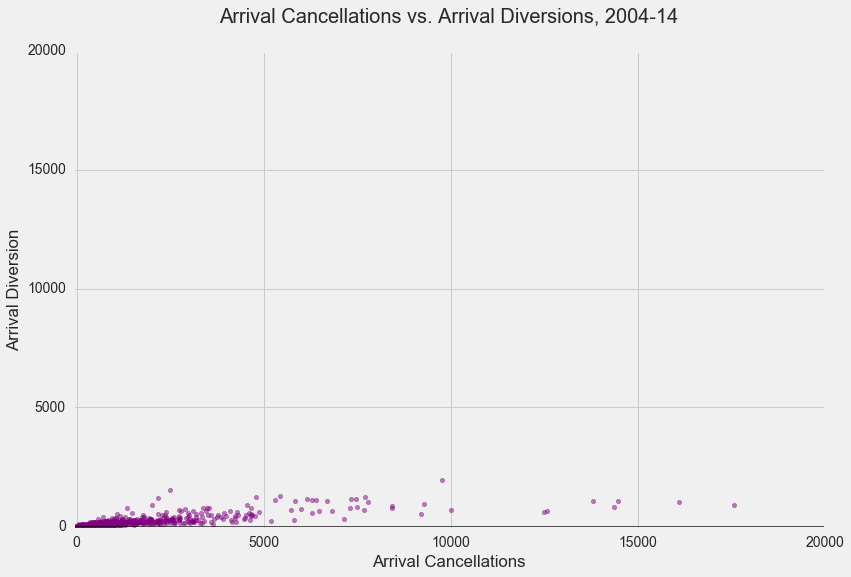

In [332]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(big_airport['arr cancel'], big_airport['arr divers'], color = "purple", \
            alpha = 0.5)
plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)
plt.title('Arrival Cancellations vs. Arrival Diversions, 2004-14', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Arrival Diversion')

# x label
plt.xlabel('Arrival Cancellations', y = 0.1)

plt.xlim([-100, 20000])
plt.ylim([-100, 20000])


plt.show()

Clearly, there are more arrival cancellations than arrival diversions.  Let's reshape to view better and break down by year:

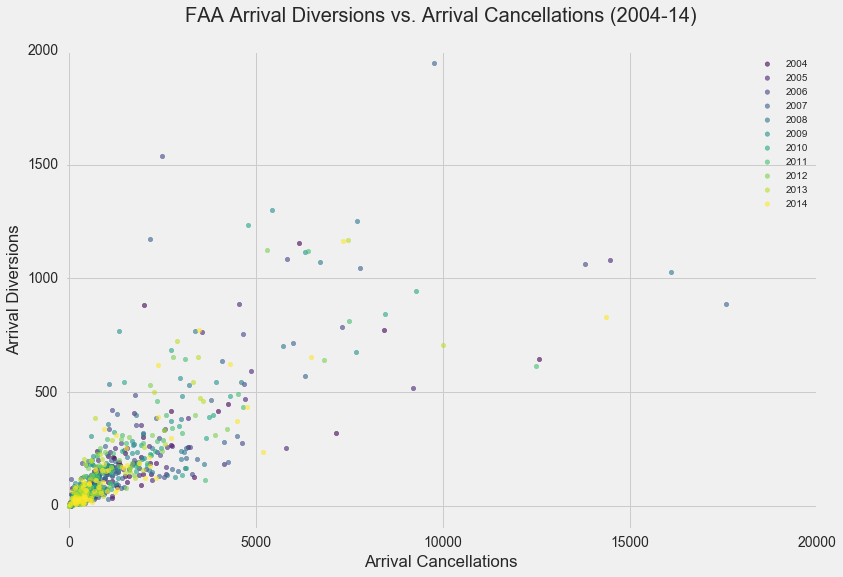

In [333]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# assign colors to ranked certifications
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
year_colors = []
for i in years:
    year_colors.append(cm.viridis((i-2004)*256/(2014-2004)))
year_dict = dict(zip(years, year_colors))

big2004 = big_airport[big_airport['year'] == 2004]
big2005 = big_airport[big_airport['year'] == 2005]
big2006 = big_airport[big_airport['year'] == 2006]
big2007 = big_airport[big_airport['year'] == 2007]
big2008 = big_airport[big_airport['year'] == 2008]
big2009 = big_airport[big_airport['year'] == 2009]
big2010 = big_airport[big_airport['year'] == 2010]
big2011 = big_airport[big_airport['year'] == 2011]
big2012 = big_airport[big_airport['year'] == 2012]
big2013 = big_airport[big_airport['year'] == 2013]
big2014 = big_airport[big_airport['year'] == 2014]

plt.scatter(big2004['arr cancel'], big2004['arr divers'], color = year_dict[2004], alpha = 0.6, label = '2004')
plt.scatter(big2005['arr cancel'], big2005['arr divers'], color = year_dict[2005], alpha = 0.6, label = '2005')
plt.scatter(big2006['arr cancel'], big2006['arr divers'], color = year_dict[2006], alpha = 0.6, label = '2006')
plt.scatter(big2007['arr cancel'], big2007['arr divers'], color = year_dict[2007], alpha = 0.6, label = '2007')
plt.scatter(big2008['arr cancel'], big2008['arr divers'], color = year_dict[2008], alpha = 0.6, label = '2008')
plt.scatter(big2009['arr cancel'], big2009['arr divers'], color = year_dict[2009], alpha = 0.6, label = '2009')
plt.scatter(big2010['arr cancel'], big2010['arr divers'], color = year_dict[2010], alpha = 0.6, label = '2010')
plt.scatter(big2011['arr cancel'], big2011['arr divers'], color = year_dict[2011], alpha = 0.6, label = '2011')
plt.scatter(big2012['arr cancel'], big2012['arr divers'], color = year_dict[2012], alpha = 0.6, label = '2012')
plt.scatter(big2013['arr cancel'], big2013['arr divers'], color = year_dict[2013], alpha = 0.6, label = '2013')
plt.scatter(big2014['arr cancel'], big2014['arr divers'], color = year_dict[2014], alpha = 0.6, label = '2014')

#plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)
plt.title('FAA Arrival Diversions vs. Arrival Cancellations (2004-14)', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Arrival Diversions')

# x label
plt.xlabel('Arrival Cancellations', y = 0.1)

plt.xlim([-100, 20000])
plt.ylim([-100, 2000])
plt.legend(loc='upper right', fontsize = 10)

plt.show()

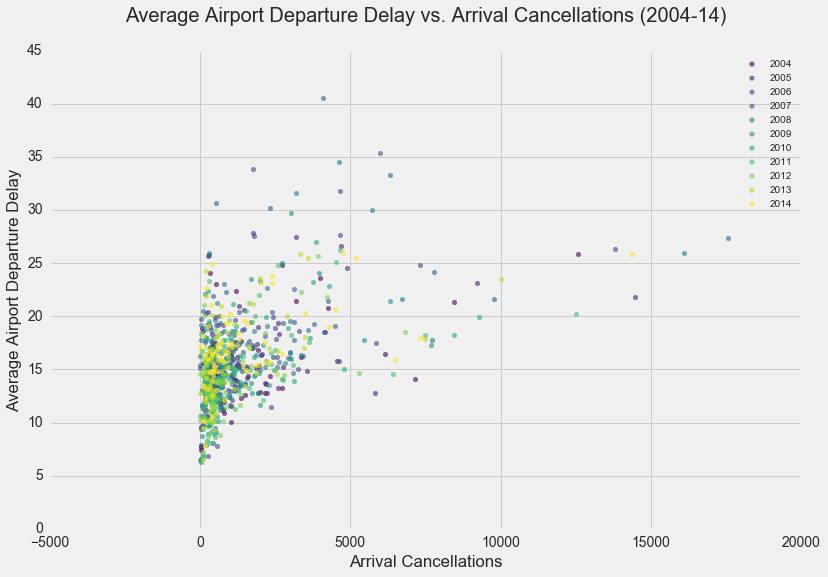

In [334]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(big2004['arr cancel'], big2004['avg ap dep del'], color = year_dict[2004], alpha = 0.6, label = '2004')
plt.scatter(big2005['arr cancel'], big2005['avg ap dep del'], color = year_dict[2005], alpha = 0.6, label = '2005')
plt.scatter(big2006['arr cancel'], big2006['avg ap dep del'], color = year_dict[2006], alpha = 0.6, label = '2006')
plt.scatter(big2007['arr cancel'], big2007['avg ap dep del'], color = year_dict[2007], alpha = 0.6, label = '2007')
plt.scatter(big2008['arr cancel'], big2008['avg ap dep del'], color = year_dict[2008], alpha = 0.6, label = '2008')
plt.scatter(big2009['arr cancel'], big2009['avg ap dep del'], color = year_dict[2009], alpha = 0.6, label = '2009')
plt.scatter(big2010['arr cancel'], big2010['avg ap dep del'], color = year_dict[2010], alpha = 0.6, label = '2010')
plt.scatter(big2011['arr cancel'], big2011['avg ap dep del'], color = year_dict[2011], alpha = 0.6, label = '2011')
plt.scatter(big2012['arr cancel'], big2012['avg ap dep del'], color = year_dict[2012], alpha = 0.6, label = '2012')
plt.scatter(big2013['arr cancel'], big2013['avg ap dep del'], color = year_dict[2013], alpha = 0.6, label = '2013')
plt.scatter(big2014['arr cancel'], big2014['avg ap dep del'], color = year_dict[2014], alpha = 0.6, label = '2014')

#plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)
plt.title('Average Airport Departure Delay vs. Arrival Cancellations (2004-14)', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Average Airport Departure Delay')

# x label
plt.xlabel('Arrival Cancellations', y = 0.1)

# plt.xlim([-100, 20000])
# plt.ylim([-100, 2000])
plt.legend(loc='upper right', fontsize = 10)

plt.show()

Let's look at some box and whisker plots, one for each year in our dataset:

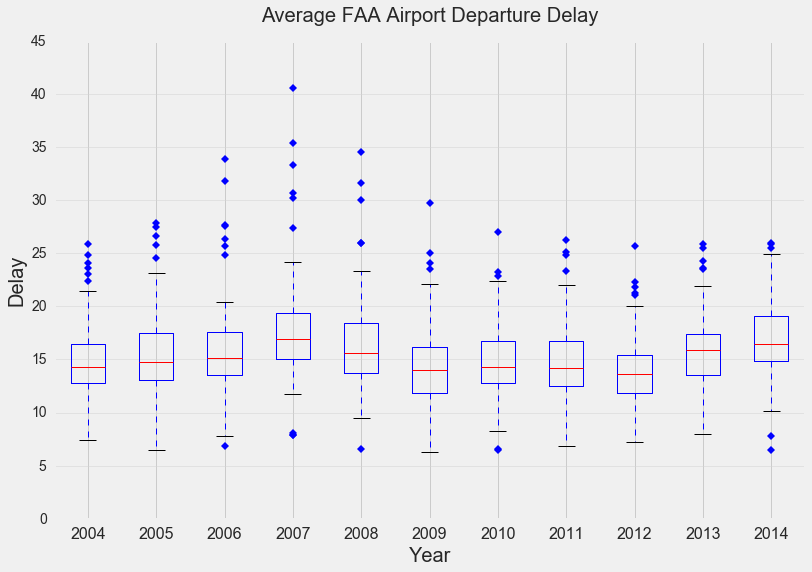

In [335]:
data = [big_airport[big_airport['year'] == 2004]['avg ap dep del'], \
        big_airport[big_airport['year'] == 2005]['avg ap dep del'], \
        big_airport[big_airport['year'] == 2006]['avg ap dep del'],
        big_airport[big_airport['year'] == 2007]['avg ap dep del'],
        big_airport[big_airport['year'] == 2008]['avg ap dep del'],
        big_airport[big_airport['year'] == 2009]['avg ap dep del'],
        big_airport[big_airport['year'] == 2010]['avg ap dep del'],
        big_airport[big_airport['year'] == 2011]['avg ap dep del'],
        big_airport[big_airport['year'] == 2012]['avg ap dep del'],
        big_airport[big_airport['year'] == 2013]['avg ap dep del'],
        big_airport[big_airport['year'] == 2014]['avg ap dep del']]
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')
plt.subplots_adjust(\
#                    left=0.075, right=0.95, top=0.9, bottom=0.25\
                   )

bp = plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Average FAA Airport Departure Delay', y =1.03)
ax1.set_xlabel('Year', fontsize = 20)
ax1.set_ylabel('Delay', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = 11
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(0, 45)
xtickNames = plt.setp(ax1, xticklabels=['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',\
                                       '2013', '2014'])
plt.setp(xtickNames, fontsize=16)

plt.show()

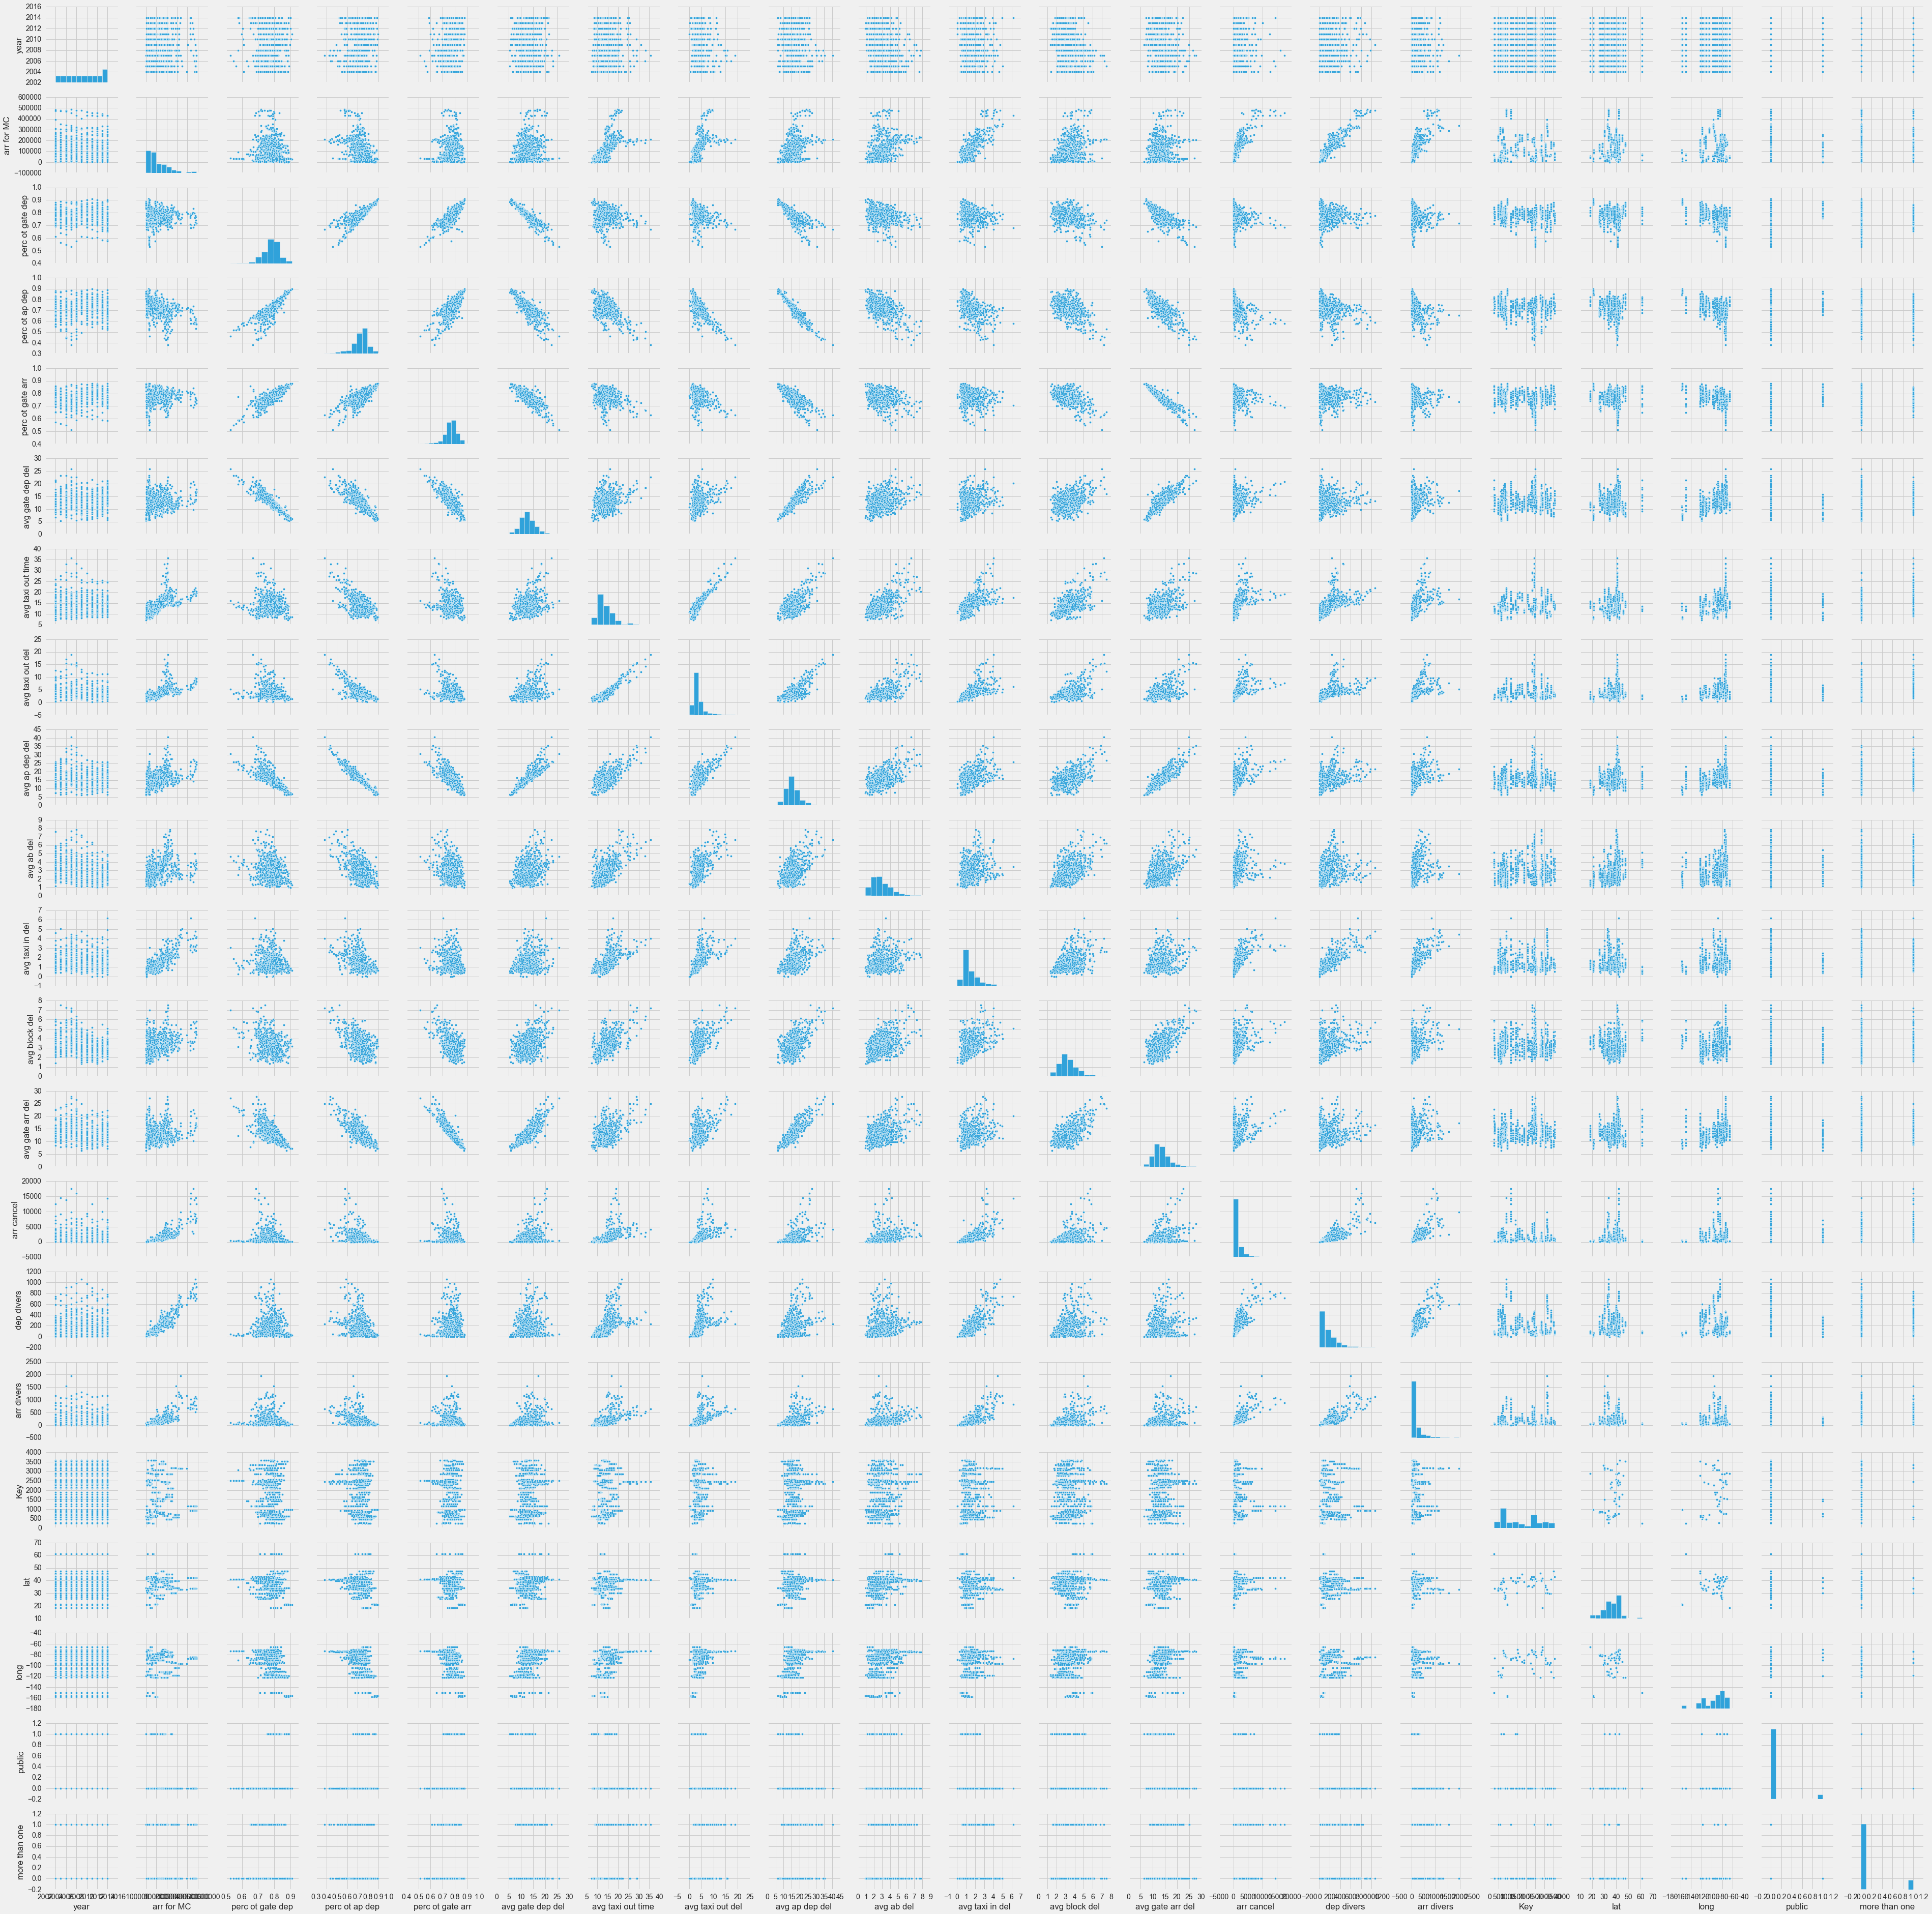

In [221]:
sns.pairplot(big_airport)

Looks like there are a bunch of correlations happening in there.  Let's check out a heatmap:

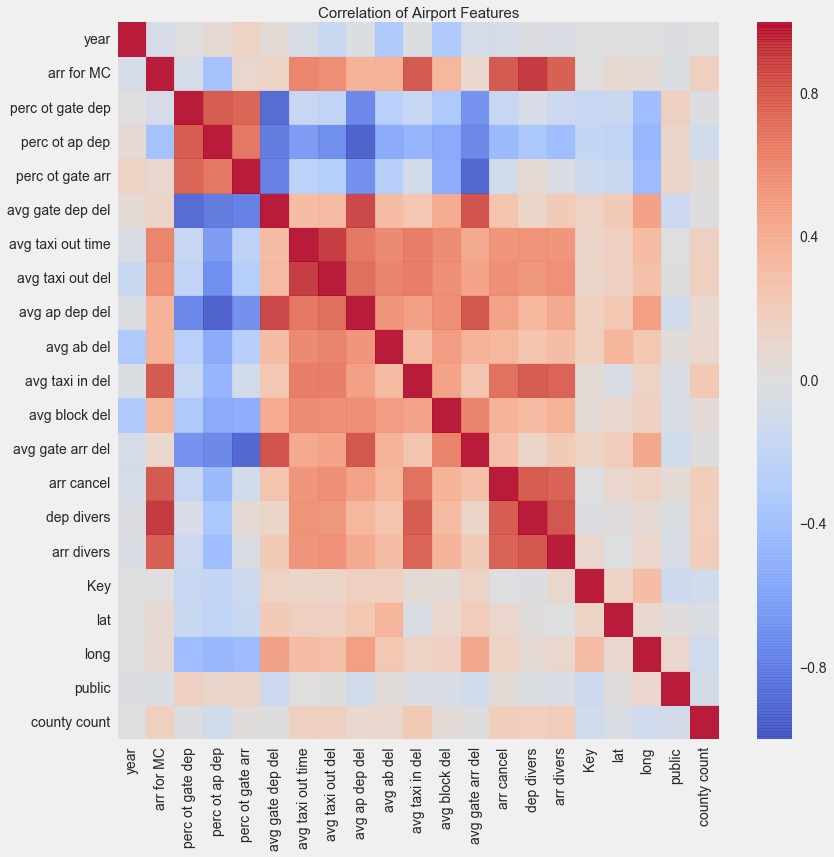

In [337]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.4)
ax = sns.heatmap(big_airport.ix[:, 1:len(big_airport.columns)].corr(), \
                 cmap = "coolwarm", alpha = 0.9)

ax.axes.set_title("Correlation of Airport Features", size = 15)

plt.show()

Let's check out some off-diagonal warms spots on the heatmap:

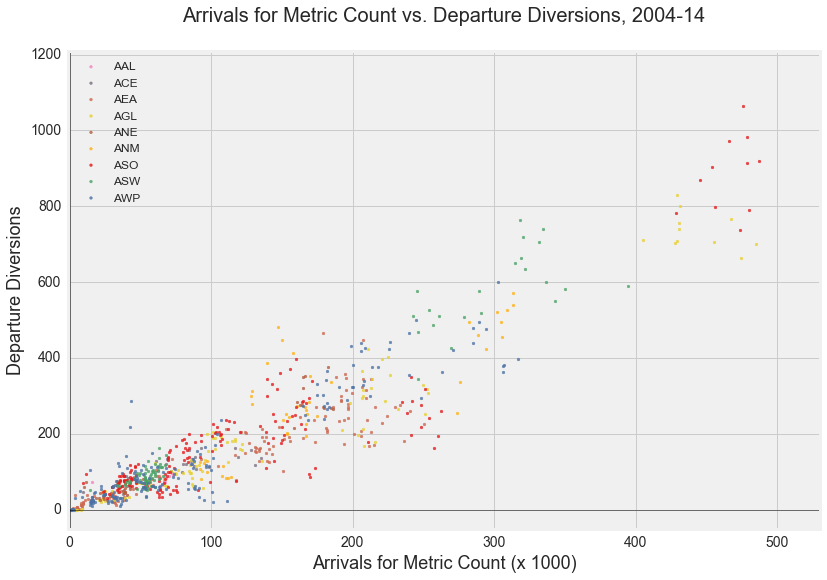

In [338]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')


ASO = big_airport[big_airport['FAA REGION'] == 'ASO']
AWP = big_airport[big_airport['FAA REGION'] == 'AWP']
ASW = big_airport[big_airport['FAA REGION'] == 'ASW']
ACE = big_airport[big_airport['FAA REGION'] == 'ACE']
AEA = big_airport[big_airport['FAA REGION'] == 'AEA']
ANM = big_airport[big_airport['FAA REGION'] == 'ANM']
AGL = big_airport[big_airport['FAA REGION'] == 'AGL']
ANE = big_airport[big_airport['FAA REGION'] == 'ANE']
AAL = big_airport[big_airport['FAA REGION'] == 'AAL']
               

plt.scatter(AAL['arr for MC']/1000, AAL['dep divers'], color = FAA_dict['AAL'], alpha = 0.8, label = 'AAL', s = 7)
plt.scatter(ACE['arr for MC']/1000, ACE['dep divers'], color = FAA_dict['ACE'], alpha = 0.8, label = 'ACE', s = 7)
plt.scatter(AEA['arr for MC']/1000, AEA['dep divers'], color = FAA_dict['AEA'], alpha = 0.8, label = 'AEA', s = 7)
plt.scatter(AGL['arr for MC']/1000, AGL['dep divers'], color = FAA_dict['AGL'], alpha = 0.8, label = 'AGL', s = 7)
plt.scatter(ANE['arr for MC']/1000, ANE['dep divers'], color = FAA_dict['ANE'], alpha = 0.8, label = 'ANE', s = 7)
plt.scatter(ANM['arr for MC']/1000, ANM['dep divers'], color = FAA_dict['ANM'], alpha = 0.8, label = 'ANM', s = 7)
plt.scatter(ASO['arr for MC']/1000, ASO['dep divers'], color = FAA_dict['ASO'], alpha = 0.8, label = 'ASO', s = 7)
plt.scatter(ASW['arr for MC']/1000, ASW['dep divers'], color = FAA_dict['ASW'], alpha = 0.8, label = 'ASW', s = 7)
plt.scatter(AWP['arr for MC']/1000, AWP['dep divers'], color = FAA_dict['AWP'], alpha = 0.8, label = 'AWP', s = 7)

plt.axhline(0, color='black', alpha = 0.6, linewidth = 0.8)
plt.axvline(0, color='black', alpha = 0.6, linewidth = 0.8)
plt.title('Arrivals for Metric Count vs. Departure Diversions, 2004-14', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Departure Diversions', fontsize = 18)

# x label
plt.xlabel('Arrivals for Metric Count (x 1000)', y = 0.1, fontsize = 18)

plt.xlim([-1000/1000, 530000/1000])
plt.ylim([-50, 1210])

plt.legend(loc='upper left', fontsize = 12)

plt.show()

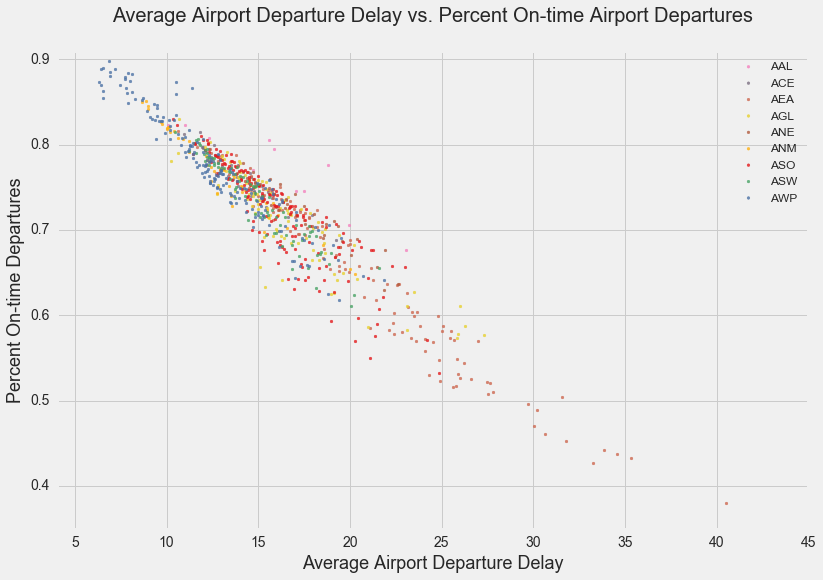

In [339]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')


plt.scatter(AAL['avg ap dep del'], AAL['perc ot ap dep'], color = FAA_dict['AAL'], alpha = 0.8, label = 'AAL', s = 7)
plt.scatter(ACE['avg ap dep del'], ACE['perc ot ap dep'], color = FAA_dict['ACE'], alpha = 0.8, label = 'ACE', s = 7)
plt.scatter(AEA['avg ap dep del'], AEA['perc ot ap dep'], color = FAA_dict['AEA'], alpha = 0.8, label = 'AEA', s = 7)
plt.scatter(AGL['avg ap dep del'], AGL['perc ot ap dep'], color = FAA_dict['AGL'], alpha = 0.8, label = 'AGL', s = 7)
plt.scatter(ANE['avg ap dep del'], ANE['perc ot ap dep'], color = FAA_dict['ANE'], alpha = 0.8, label = 'ANE', s = 7)
plt.scatter(ANM['avg ap dep del'], ANM['perc ot ap dep'], color = FAA_dict['ANM'], alpha = 0.8, label = 'ANM', s = 7)
plt.scatter(ASO['avg ap dep del'], ASO['perc ot ap dep'], color = FAA_dict['ASO'], alpha = 0.8, label = 'ASO', s = 7)
plt.scatter(ASW['avg ap dep del'], ASW['perc ot ap dep'], color = FAA_dict['ASW'], alpha = 0.8, label = 'ASW', s = 7)
plt.scatter(AWP['avg ap dep del'], AWP['perc ot ap dep'], color = FAA_dict['AWP'], alpha = 0.8, label = 'AWP', s = 7)

plt.axvline(0, color='black', alpha = 0.6, linewidth = 1)
plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)
plt.title('Average Airport Departure Delay vs. Percent On-time Airport Departures', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Percent On-time Departures', fontsize = 18)

# x label
plt.xlabel('Average Airport Departure Delay', y = 0.1, fontsize = 18)

plt.xlim([4, 45])
plt.ylim([0.35, 0.91])

plt.legend(loc='upper right', fontsize = 12)

plt.show()

We're not huge fans of those warm composite spots in the heatmap, are we?  We also don't know how those percentage features were calculated; our other features probably contain a lot of that information already.  Let's take out some features (NOT DONE as default for rest of analysis):

In [341]:
big_airport = big_airport.drop(['perc ot gate dep', 'perc ot ap dep', 'perc ot gate arr', \
                               'avg taxi out time', 'dep divers', 'arr divers', 'avg gate dep del'], axis = 1)

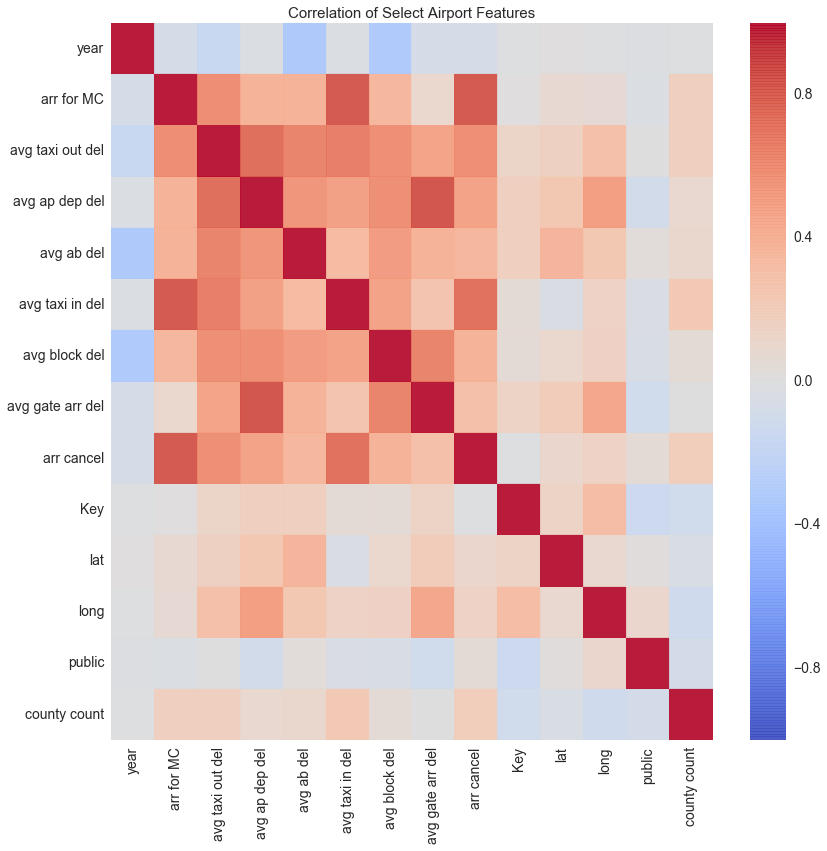

In [342]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.4)
ax = sns.heatmap(big_airport.ix[:, 1:len(big_airport.columns)].corr(), \
                 cmap = "coolwarm", alpha = 0.9)

ax.axes.set_title("Correlation of Select Airport Features", size = 15)

plt.show()

Eh, kind of looks better.  Would be nice to have raw data instead of all these averages... let's push onward for now!  

#### Dummy time:

In [343]:
big_airport.columns

Index([u'airport', u'year', u'arr for MC', u'avg taxi out del',
       u'avg ap dep del', u'avg ab del', u'avg taxi in del', u'avg block del',
       u'avg gate arr del', u'arr cancel', u'Key', u'FAA REGION', u'CITY',
       u'STATE', u'lat', u'long', u'public', u'county count'],
      dtype='object')

In [344]:
big_dumbairport = pd.concat([big_airport.drop(['FAA REGION', 'CITY'], axis = 1), \
                             pd.get_dummies(big_airport['FAA REGION'])], axis = 1)
del big_dumbairport['AAL']


big_dumbairport = pd.concat([big_dumbairport, pd.get_dummies(big_airport['airport'])], \
                            axis = 1)
del big_dumbairport['ABQ']


big_dumbairport = pd.concat([big_dumbairport, pd.get_dummies(big_airport['year'])], \
                            axis = 1)
del big_dumbairport[2004]


big_dumbairport = pd.concat([big_dumbairport.drop('STATE', axis = 1), pd.get_dummies(big_airport['STATE'])], \
                            axis = 1)
del big_dumbairport['AL']

In [345]:
big_dumbairport.shape

(790, 141)

#### Are there any unique values? 

Each airport code appears once per yearly observation, which range from 2004 to 2014 (most have all years in that range with the exception of the ones we just examined and edited to merge the dataframes).  Observations brought in from the airports dataframe are repeated for same airport in different years.  All other values are presumably unique (but may match incidentally to a few decimal places).

### Define the Data

In [346]:
X = big_dumbairport.ix[:, 1:len(big_dumbairport.columns) + 1]
del X['avg ap dep del']
X['intercept'] = 1
y = big_dumbairport['avg ap dep del']

In [347]:
X.shape

(790, 140)

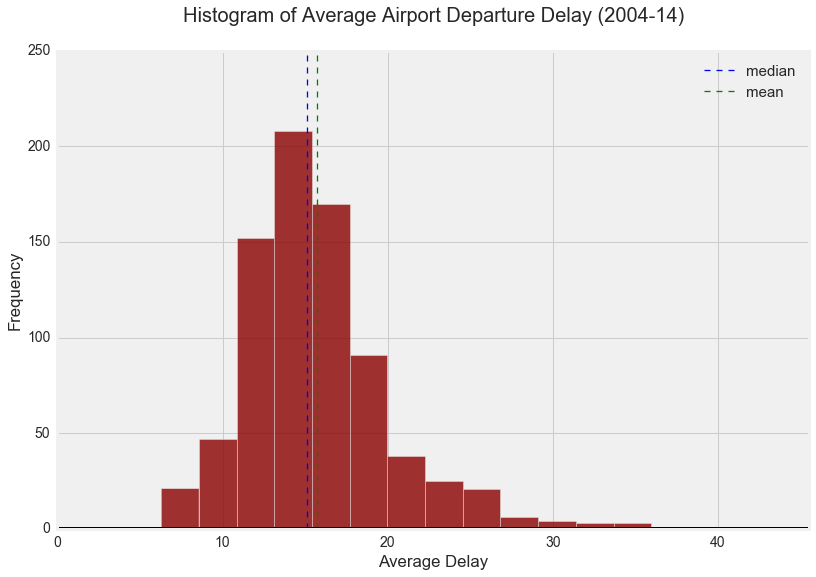

In [348]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(big_dumbairport['avg ap dep del'], color = 'darkred', bins = 15, alpha = 0.8)
plt.axvline(big_dumbairport['avg ap dep del'].median(), color='b', linestyle='dashed', linewidth=1.3, \
            label = 'median')
plt.axvline(big_dumbairport['avg ap dep del'].mean(), color='g', linestyle='dashed', linewidth=1.3, \
            label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of Average Airport Departure Delay (2004-14)', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Average Delay')

plt.xlim([0, max(big_dumbairport['avg ap dep del'] + 5)])
#plt.ylim([0, 40])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

In [349]:
big_dumbairport['avg ap dep del'].describe()

count    790.000000
mean      15.706139
std        4.376767
min        6.290000
25%       12.895000
50%       15.115000
75%       17.557500
max       40.510000
Name: avg ap dep del, dtype: float64

Histogram looks normally distributed around mean of about 16 minutes with a slight right skew.

In [350]:
big_dumbairport.sort('avg ap dep del', ascending = False).head(10)[['airport', 'year',\
                                                                    'avg ap dep del']]

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


airport    year  avg ap dep del
333     JFK  2007.0           40.51
223     EWR  2007.0           35.34
224     EWR  2008.0           34.57
332     JFK  2006.0           33.84
366     LGA  2007.0           33.26
222     EWR  2006.0           31.80
334     JFK  2008.0           31.57
267     HPN  2007.0           30.62
571     PHL  2007.0           30.20
367     LGA  2008.0           30.04

And, more recently:

In [351]:
big_dumbairport[big_dumbairport['year'] == 2014].sort('avg ap dep del', \
                                                ascending = False).head(10)[['airport', 'year', 'avg ap dep del']]

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


airport    year  avg ap dep del
373     LGA  2014.0           25.92
538     ORD  2014.0           25.88
230     EWR  2014.0           25.46
274     HPN  2014.0           24.89
340     JFK  2014.0           23.83
417     MDW  2014.0           23.11
285     IAD  2014.0           23.11
439     MHT  2014.0           22.62
428     MEM  2014.0           21.10
702     SFO  2014.0           20.69

Scale the data:

In [352]:
Xs = StandardScaler().fit_transform(X.astype(float))
Xs = pd.DataFrame(Xs, columns = X.columns[0:len(X.columns)])
len(Xs.columns)

140

In [353]:
len(big_dumbairport.columns)

141

That's fine, since we didn't originally take 'airport,' and the target variable into X-- but we added an intercept.

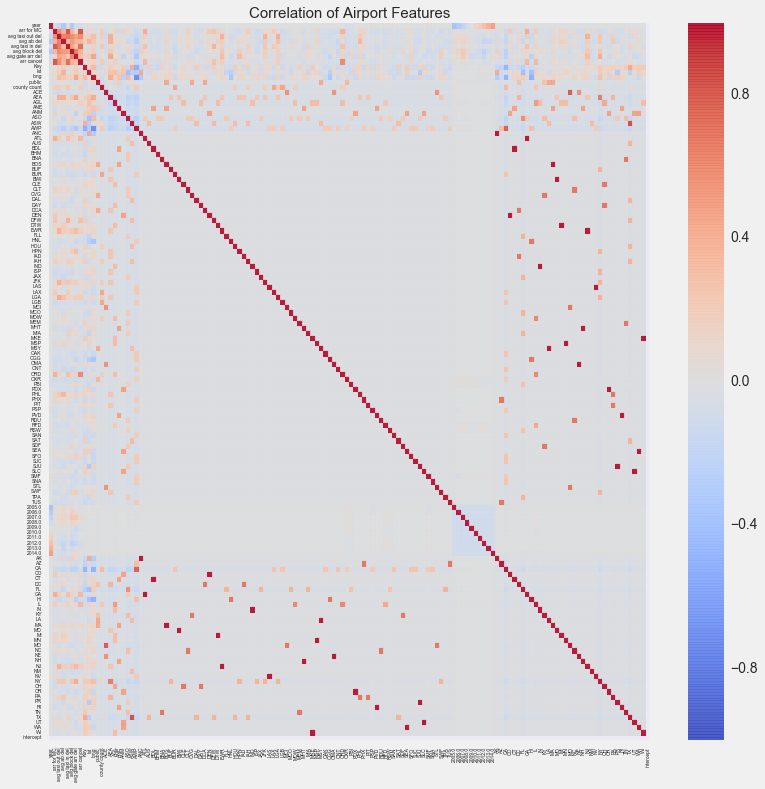

In [354]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.4)
ax = sns.heatmap(Xs.corr(), cmap = "coolwarm", alpha = 0.9)

ax.axes.set_title("Correlation of Airport Features", size = 15)
plt.xticks(rotation = 90, fontsize = 5)
plt.yticks(fontsize = 5)
plt.show()

Let's just look at 2014 since we're not doing a serious time series analysis and it's the most recent year we have.  (Also, remember from the box and whisker plots that it resembles previous years.)

In [355]:
big_airport.columns

Index([u'airport', u'year', u'arr for MC', u'avg taxi out del',
       u'avg ap dep del', u'avg ab del', u'avg taxi in del', u'avg block del',
       u'avg gate arr del', u'arr cancel', u'Key', u'FAA REGION', u'CITY',
       u'STATE', u'lat', u'long', u'public', u'county count'],
      dtype='object')

In [356]:
small_airport = pd.concat([big_airport.drop(['FAA REGION', 'STATE', 'airport', 'lat', 'long', 'Key', 'CITY'], \
                                            axis = 1), pd.get_dummies(big_airport['FAA REGION'])], axis = 1)
del small_airport['AAL']

small_airport = small_airport[small_airport['year'] == 2014]

In [357]:
for column in small_airport.columns[1:len(small_airport.columns)]:
    if sum(small_airport[column]) == 0:
        print column

In [358]:
X_small = small_airport.ix[:, 1:len(small_airport.columns) + 1]
del X_small['avg ap dep del']
X_small['intercept'] = 1
y = small_airport['avg ap dep del']

In [359]:
X_small.columns

Index([u'arr for MC', u'avg taxi out del', u'avg ab del', u'avg taxi in del',
       u'avg block del', u'avg gate arr del', u'arr cancel', u'public',
       u'county count', u'ACE', u'AEA', u'AGL', u'ANE', u'ANM', u'ASO', u'ASW',
       u'AWP', u'intercept'],
      dtype='object')

In [360]:
Xs2 = StandardScaler().fit_transform(X_small.astype(float))
Xs2 = pd.DataFrame(Xs2, columns = X_small.columns[0:len(X_small.columns)])
len(Xs2.columns)

18

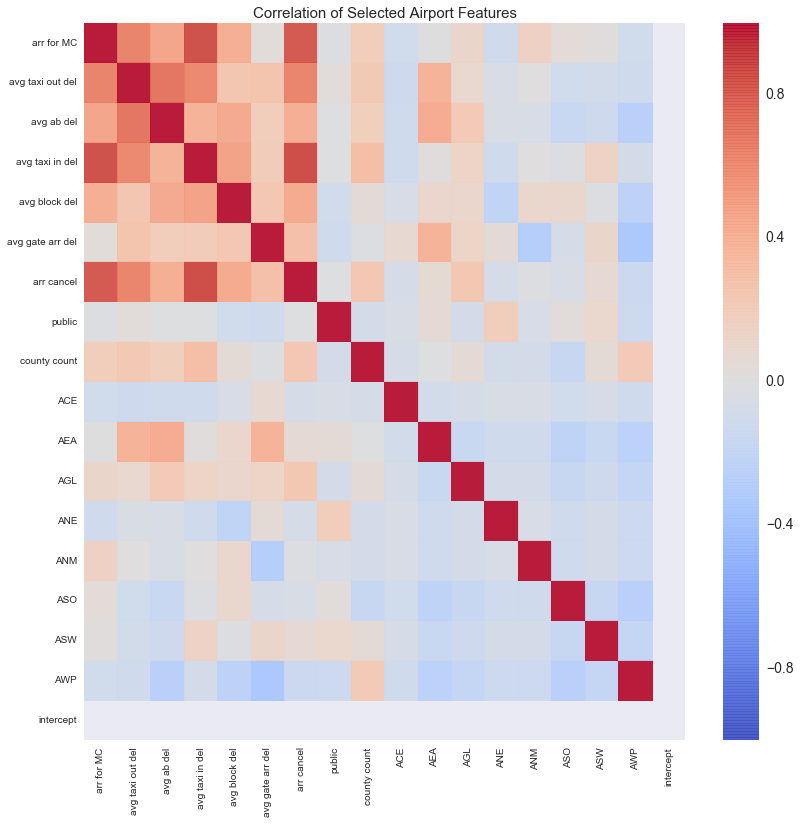

In [361]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.4)
ax = sns.heatmap(Xs2.corr(), cmap = "coolwarm", alpha = 0.9)

ax.axes.set_title("Correlation of Selected Airport Features", size = 15)
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

#### What is the value of understanding correlations before PCA? 

PCA does the gruntwork, but if we know two features have correlation near to 1.0 beforehand, we can manually reduce featurespace dimension by removing one of them.  This will also lessen the overcontribution of the correlated features' underlying factors.  Our principal components obtained will also not have as high dimension if we reduce number of features initially.

#### Validate your findings using statistical analysis

(above)

#### How can you improve your overall analysis? 

Have a bigger screen to do all columns at once.  Have better understanding how calculated columns are produced so we don't start off with so many columns. 

### Perform a PCA

In [362]:
covmat = np.cov(Xs2.T)
eigenValues, eigenVectors = np.linalg.eig(covmat)

# sort eigval/vec pairs in order of descending eigval
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

In [363]:
eigenPairs = pd.DataFrame([(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))])
eigenPairs.columns = ['eigval', 'eigvec']
eigvals = []
eigvecs = []
for i in range(len(eigenPairs)):
    eigvals.append(eigenPairs.ix[i,0])
    eigvecs.append(eigenPairs.ix[i,1])
#    print eigenPairs.ix[i,0] 
print eigvals[0:98]

[4.348597664105756, 1.8504275312277785, 1.5577982412548139, 1.3777788294034727, 1.3479777346461306, 1.1757894013849577, 1.1452953624970361, 1.0221636754817627, 0.85573715011058626, 0.70756955834783708, 0.64509994040725149, 0.55386015982058145, 0.32023572129306044, 0.13956817306225458, 0.10814860436059462, 0.07869714938723571, 0.01163191480308608, 0.0]


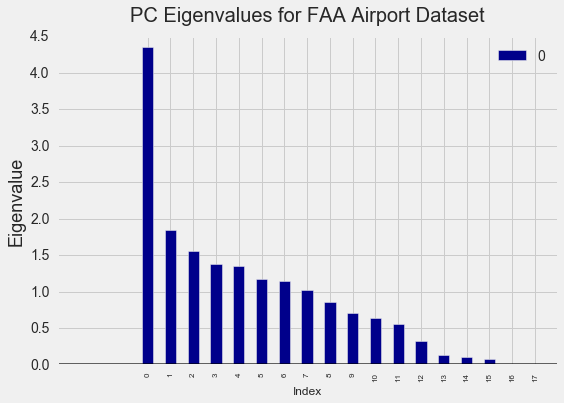

In [364]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

eigs = pd.DataFrame(eigvals)

eigs.plot.bar(color = 'darkblue')

plt.title('PC Eigenvalues for FAA Airport Dataset', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Eigenvalue', fontsize = 18)

# x label
plt.xlabel('Index', fontsize = 12)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 8)
plt.xlim([-4, len(eigs)])
# plt.ylim([-0.1, 1.1])
plt.show()

In [365]:
totalEigen = sum(eigvals)

varExpl = [(i/totalEigen)*100 for i in eigvals]

In [366]:
cvarex = np.cumsum(varExpl)
cvarex

array([  25.21455788,   35.9439276 ,   44.97653925,   52.96534087,
         60.78134622,   67.59894863,   74.23973687,   80.16656827,
         85.12840552,   89.23111977,   92.97161522,   96.18307329,
         98.03990226,   98.8491631 ,   99.47624324,   99.93255444,
        100.        ,  100.        ])

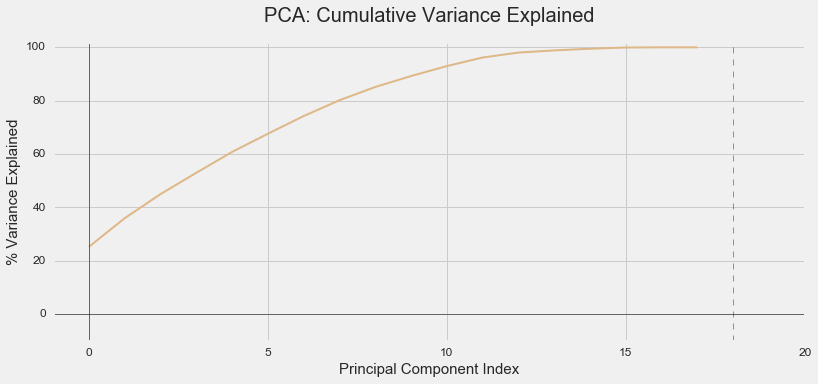

In [367]:
plt.figure(figsize=(12,5))
plt.style.use('fivethirtyeight')
ax = plt.gca()
ax.set_ylabel('% Variance Explained', fontsize=15)
ax.set_xlabel('Principal Component Index', fontsize=15)
ax.set_title('PCA: Cumulative Variance Explained', fontsize=20, y = 1.05)
plt.axvline(len(eigs), color='black', linestyle='dashed', alpha = 0.5, linewidth=0.8)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.plot(cvarex, color = 'burlywood', linewidth = 2)
plt.xlim([-1, len(eigs)+2])
plt.ylim([-10, 102])
plt.axhline(0, color='black', alpha = 0.5, linewidth = 1)
plt.axvline(0, color='black', alpha = 0.5, linewidth = 1)
plt.show()

So, we can explain almost a quarter of the variance in our dataset with the first principal component; about half the variance with the first four; and over 95% with the first fourteen.

In [368]:
Xs2.columns

Index([u'arr for MC', u'avg taxi out del', u'avg ab del', u'avg taxi in del',
       u'avg block del', u'avg gate arr del', u'arr cancel', u'public',
       u'county count', u'ACE', u'AEA', u'AGL', u'ANE', u'ANM', u'ASO', u'ASW',
       u'AWP', u'intercept'],
      dtype='object')

In [197]:
n = len(Xs2)
plot_colors = []
for i in range(0, 256, 256/n):
    plot_colors.append(cm.Accent(i))

cv = KFold(len(X_small), n_folds = n, shuffle=False)


def do_plot(model, m=1):
    for fold, color in zip(cv, plot_colors):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        plt.scatter(y_pred, y_test, color=color)
        plt.plot([5,25],[5,25], linewidth = 0.3, color = 'grey')
        plt.text(25,30, "R^2: "+str(m), fontsize=20)
    return

In [188]:
ab = AdaBoostRegressor(n_estimators = 100)

scores = cross_val_score(ab, Xs2, y, cv=cv)
scores.mean()

0.0

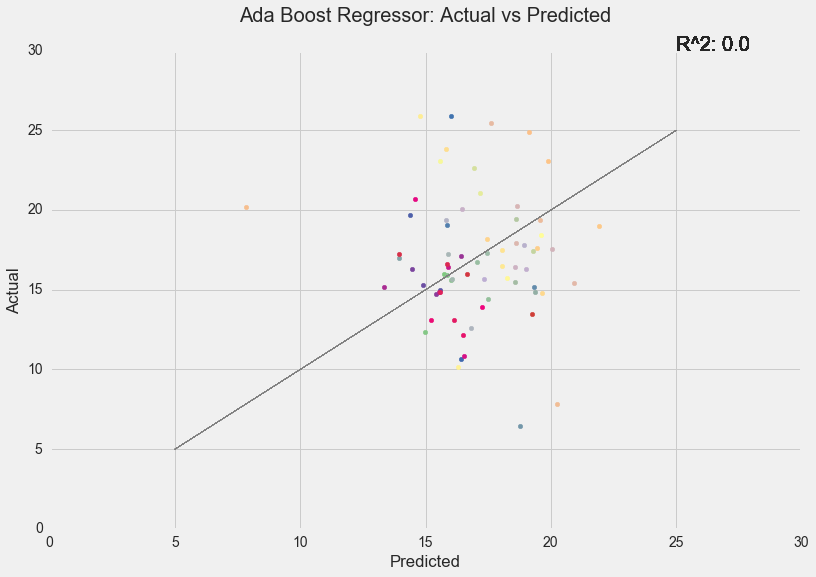

In [198]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ada Boost Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(ab, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


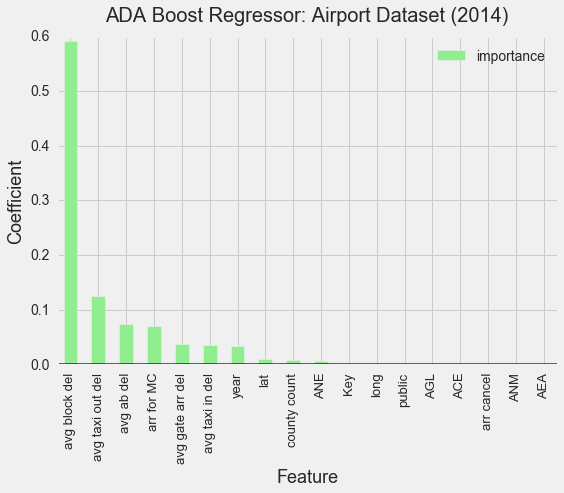

In [199]:
ab.fit(Xs2, y)
features = sorted(zip(map(lambda x: round(x, 4), ab.feature_importances_), Xs.columns), 
             reverse=True)
features_ab = pd.DataFrame(features, columns = ['importance', 'feature'])
features_ab = features_ab.sort('importance', ascending = False)
features_ab = features_ab.set_index('feature', drop = True)


plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_ab[0:19].plot.bar(color = 'lightgreen')

plt.title('ADA Boost Regressor: Airport Dataset (2014)', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=90, fontsize = 13)
plt.show()

Here is a dataframe showing coordinates with respect to our original features.  The first 10 eigenvectors explain over 90% of the variance in our dataset.

In [200]:
big_deal = pd.DataFrame()
for i in range(0, len(eigenPairs)):
    lil_eig = pd.DataFrame(eigenPairs['eigvec'][i])
    big_deal = pd.concat([big_deal, lil_eig], axis = 1)
big_deal = big_deal.set_index(Xs2.columns)
big_deal.columns = range(0,len(eigenPairs))
big_deal.sort(0, ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


0         1         2         3         4         5   \
arr cancel        0.422789  0.135928  0.073571 -0.153091 -0.058684  0.049341   
avg taxi in del   0.417716  0.219920  0.096034 -0.170309 -0.039950 -0.064270   
arr for MC        0.403966  0.259796  0.148850 -0.021663  0.119584  0.012769   
avg taxi out del  0.395122 -0.066678 -0.165324  0.041166  0.226846 -0.049649   
avg ab del        0.349300 -0.197705 -0.164066  0.186259  0.164546  0.080725   
avg block del     0.290260 -0.026840  0.237409  0.225828 -0.151862 -0.068303   
avg gate arr del  0.182636 -0.467679 -0.037896 -0.149544 -0.353997 -0.061226   
county count      0.150928  0.267422 -0.396702 -0.139812 -0.102867 -0.116415   
AEA               0.145666 -0.490544 -0.297963  0.192843  0.189016 -0.264708   
AGL               0.125941 -0.009900 -0.021007  0.067543 -0.312401  0.614421   
ASW               0.014437  0.027594  0.116559 -0.607726 -0.227397 -0.133223   
ANM               0.002494  0.211437  0.202132  0.299407  0.302332  0.336251   
intercept         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
public           -0.017751 -0.112081  0.130846 -0.402255  0.482375 -0.011637   
ASO              -0.039096  0.020610  0.558743  0.169206  0.013138 -0.427677   
ACE              -0.068232 -0.111330  0.037568  0.032213 -0.315011  0.180122   
ANE              -0.073917 -0.164138 -0.012237 -0.350421  0.366905  0.359039   
AWP              -0.125692  0.438922 -0.468235  0.052857  0.004908 -0.198826   

                        6         7         8         9         10        11  \
arr cancel        0.060172  0.138011 -0.069096  0.189865  0.049190  0.182132   
avg taxi in del  -0.001843  0.107488 -0.067672  0.109775 -0.022155  0.107146   
arr for MC       -0.012986  0.141785 -0.010072  0.140667  0.125605 -0.098063   
avg taxi out del  0.023514  0.106909  0.008628  0.059295  0.302895 -0.139145   
avg ab del        0.039792 -0.098987  0.182273 -0.204155 -0.081624 -0.525818   
avg block del    -0.094803 -0.106561 -0.035145 -0.135112 -0.791010 -0.020421   
avg gate arr del  0.020022  0.042513 -0.309033  0.103242 -0.016966  0.397631   
county count      0.058881 -0.013855  0.047184 -0.775041  0.049800  0.291002   
AEA              -0.192618 -0.069467  0.043485  0.077734  0.084424  0.187887   
AGL               0.360178 -0.348267  0.274289  0.073683  0.113007  0.118676   
ASW              -0.440694 -0.316483  0.028372 -0.028697  0.083201 -0.321300   
ANM              -0.559491 -0.079655 -0.172276 -0.118047  0.107742  0.328706   
intercept         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
public            0.077581  0.014108  0.596650  0.052439 -0.244831  0.341338   
ASO               0.409272  0.040359 -0.013984 -0.216883  0.220130  0.022444   
ACE              -0.222102  0.788197  0.323893 -0.111894 -0.004196 -0.091204   
ANE               0.262663  0.223068 -0.536253 -0.182229 -0.186432 -0.142485   
AWP               0.123692  0.096181 -0.044874  0.368197 -0.269887  0.019315   

                        12        13        14        15        16   17  
arr cancel        0.178147 -0.309156 -0.728552 -0.093432  0.046167  0.0  
avg taxi in del   0.176725  0.355170  0.379317 -0.625350 -0.026722  0.0  
arr for MC        0.209700 -0.313384  0.450920  0.565972 -0.028954  0.0  
avg taxi out del -0.486514  0.541361 -0.191510  0.244136 -0.061282  0.0  
avg ab del       -0.199099 -0.440523  0.068968 -0.359013  0.083190  0.0  
avg block del    -0.016008  0.227616 -0.098404  0.226426  0.031243  0.0  
avg gate arr del -0.440960 -0.274311  0.239499  0.015103 -0.031811  0.0  
county count      0.034939 -0.032050  0.008894  0.092339 -0.007910  0.0  
AEA               0.486222  0.101688  0.022627  0.060033  0.404007  0.0  
AGL               0.040454  0.152575  0.071499  0.081864  0.329643  0.0  
ASW              -0.068169  0.042804 -0.041068  0.076710  0.355595  0.0  
ANM              -0.238422 -0.084959  0.017626 -0.105561  0.249308  0.0  
intercept         0.

In [201]:
PC_corr = big_deal.corr()
PC_corr

0         1         2         3         4         5         6   \
0   1.000000  0.011761 -0.006897  0.133047 -0.055546 -0.042720  0.015998   
1   0.011761  1.000000  0.000139 -0.002678  0.001118  0.000860 -0.000322   
2  -0.006897  0.000139  1.000000  0.001570 -0.000656 -0.000504  0.000189   
3   0.133047 -0.002678  0.001570  1.000000  0.012647  0.009727 -0.003643   
4  -0.055546  0.001118 -0.000656  0.012647  1.000000 -0.004061  0.001521   
5  -0.042720  0.000860 -0.000504  0.009727 -0.004061  1.000000  0.001170   
6   0.015998 -0.000322  0.000189 -0.003643  0.001521  0.001170  1.000000   
7  -0.121379  0.002443 -0.001433  0.027637 -0.011538 -0.008874  0.003323   
8  -0.044464  0.000895 -0.000525  0.010124 -0.004227 -0.003251  0.001217   
9   0.108675 -0.002187  0.001283 -0.024744  0.010331  0.007945 -0.002975   
10  0.087246 -0.001756  0.001030 -0.019865  0.008294  0.006379 -0.002389   
11 -0.119976  0.002415 -0.001416  0.027318 -0.011405 -0.008771  0.003285   
12  0.142813 -0.002874  0.001686 -0.032518  0.013576  0.010441 -0.003910   
13  0.013220 -0.000266  0.000156 -0.003010  0.001257  0.000967 -0.000362   
14 -0.057645  0.001160 -0.000680  0.013125 -0.005480 -0.004214  0.001578   
15 -0.033798  0.000680 -0.000399  0.007696 -0.003213 -0.002471  0.000925   
16 -0.638271  0.012847 -0.007534  0.145330 -0.060674 -0.046664  0.017475   
17 -0.185397  0.003732 -0.002188  0.042214 -0.017624 -0.013554  0.005076   

          7         8         9         10        11        12        13  \
0  -0.121379 -0.044464  0.108675  0.087246 -0.119976  0.142813  0.013220   
1   0.002443  0.000895 -0.002187 -0.001756  0.002415 -0.002874 -0.000266   
2  -0.001433 -0.000525  0.001283  0.001030 -0.001416  0.001686  0.000156   
3   0.027637  0.010124 -0.024744 -0.019865  0.027318 -0.032518 -0.003010   
4  -0.011538 -0.004227  0.010331  0.008294 -0.011405  0.013576  0.001257   
5  -0.008874 -0.003251  0.007945  0.006379 -0.008771  0.010441  0.000967   
6   0.003323  0.001217 -0.002975 -0.002389  0.003285 -0.003910 -0.000362   
7   1.000000 -0.009236  0.022574  0.018123 -0.024922  0.029666  0.002746   
8  -0.009236  1.000000  0.008270  0.006639 -0.009130  0.010867  0.001006   
9   0.022574  0.008270  1.000000 -0.016226  0.022314 -0.026561 -0.002459   
10  0.018123  0.006639 -0.016226  1.000000  0.017914 -0.021324 -0.001974   
11 -0.024922 -0.009130  0.022314  0.017914  1.000000  0.029323  0.002714   
12  0.029666  0.010867 -0.026561 -0.021324  0.029323  1.000000 -0.003231   
13  0.002746  0.001006 -0.002459 -0.001974  0.002714 -0.003231  1.000000   
14 -0.011974 -0.004387  0.010721  0.008607 -0.011836  0.014089  0.001304   
15 -0.007021 -0.002572  0.006286  0.005046 -0.006940  0.008261  0.000765   
16 -0.132585 -0.048569  0.118707  0.095301 -0.131053  0.155998  0.014441   
17 -0.038512 -0.014108  0.034481  0.027682 -0.038067  0.045312  0.004195   

          14        15        16        17  
0  -0.057645 -0.033798 -0.638271 -0.185397  
1   0.001160  0.000680  0.012847  0.003732  
2  -0.000680 -0.000399 -0.007534 -0.002188  
3   0.013125  0.007696  0.145330  0.042214  
4  -0.005480 -0.003213 -0.060674 -0.017624  
5  -0.004214 -0.002471 -0.046664 -0.013554  
6   0.001578  0.000925  0.017475  0.005076  
7  -0.011974 -0.007021 -0.132585 -0.038512  
8  -0.004387 -0.002572 -0.048569 -0.014108  
9   0.010721  0.006286  0.118707  0.034481  
10  0.008607  0.005046  0.095301  0.027682  
11 -0.011836 -0.006940 -0.131053 -0.038067  
12  0.014089  0.008261  0.155998  0.045312  
13  0.001304  0.000765  0.014441  0.004195  
14  1.000000 -0.003334 -0.062967 -0.018290  
15 -0.003334  1.000000 -0.036919 -0.010724  
16 -0.062967 -0.036919  1.000000 -0.202513  
17 -0.018290 -0.010724 -0.202513  1.000000

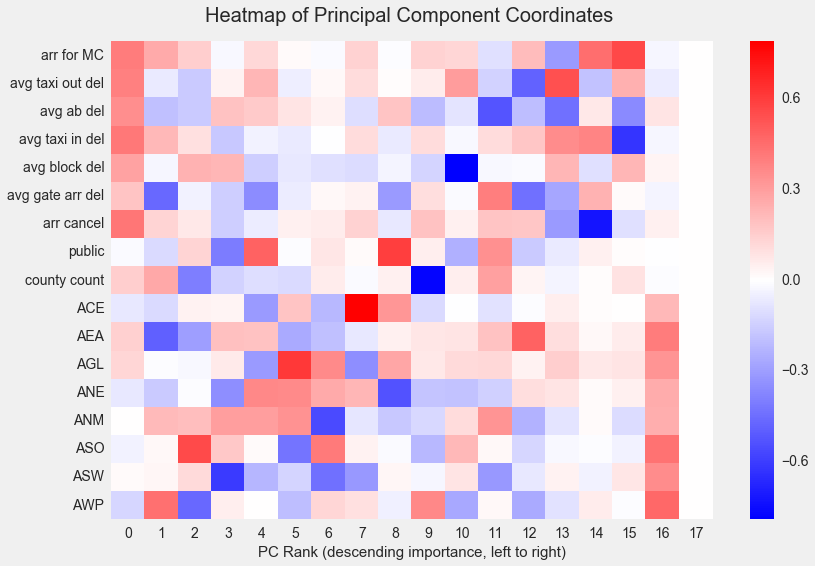

In [202]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

ax = sns.heatmap(big_deal.ix[:-1,:], cmap = "bwr", alpha = 1.0)

ax.axes.set_title('Heatmap of Principal Component Coordinates ', size = 20, y = 1.03)
ax.set_xlabel('PC Rank (descending importance, left to right)', fontsize=15)

plt.show()


 Here, we see the features from the operations dataframe are most important in explaining variance.  This makes sense, because it is information about where planes physically are and it is accumulated information.  FAA region does not seem to play a large role in explaining the variance of our dataset; the first correlations we note with respect to FAA region are negative with respect to departure delay in AEA (Eastern Atlantic) and positive with respect to the same in AWP (Western Pacific).  

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied

In [203]:
pca3d = PCA(n_components=3)
print pca3d.fit(Xs2).components_
Xpca = pca3d.fit_transform(Xs2)

[[-0.40396568 -0.3951224  -0.34930008 -0.41771644 -0.29025971 -0.18263583
  -0.42278938  0.0177512  -0.15092772  0.0682323  -0.14566631 -0.12594075
   0.07391684 -0.00249442  0.03909589 -0.01443699  0.12569222  0.        ]
 [ 0.25979607 -0.06667815 -0.19770532  0.21991966 -0.02683972 -0.46767903
   0.13592827 -0.11208051  0.26742172 -0.11133022 -0.49054406 -0.00990044
  -0.16413799  0.21143668  0.02061006  0.02759399  0.43892159  0.        ]
 [-0.14885026  0.16532384  0.16406645 -0.09603389 -0.23740891  0.03789563
  -0.07357059 -0.13084623  0.39670226 -0.03756767  0.29796337  0.02100691
   0.01223744 -0.20213225 -0.55874335 -0.1165585   0.46823519 -0.        ]]


In [204]:
pca = pd.DataFrame(Xpca, columns = ['PC1', 'PC2', 'PC3'])
pca.head(1)

PC1       PC2       PC3
0  1.537988 -0.153519 -0.293009

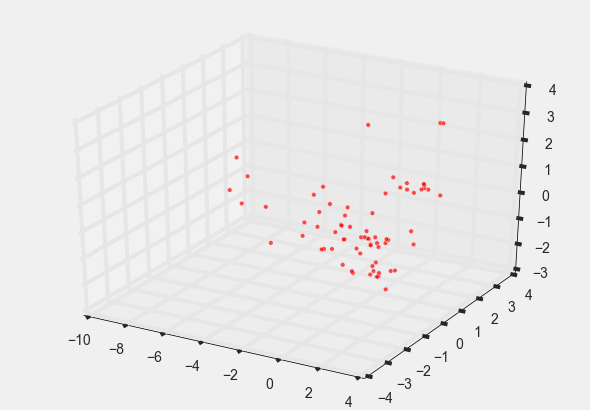

In [407]:
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(pca['PC1'], pca['PC2'], pca['PC3'], zdir='z',c='red', alpha=.7)
plt.show()